# Getting Started

This notebook is intended to help data scientists working with the [BackBlaze](https://www.backblaze.com/b2/hard-drive-test-data.html) dataset to get started and to provide some suggestions on additional feature selection and preprocessing. We will also provide an example for how to prepare the data for modeling and provide some baseline results. 

This notebook has the following sections:

1. Suggested feature selection and NaN handling 
2. Reusable function for preprocessing remaining data 
3. Simple exploratory analysis and graphing
4. Naive models and baselines
5. Simple ML models

**warning: Running this whole notebook requires about 12Gb of memory**

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import dask.dataframe as dd

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# 1. Suggested Feature Selection and NaN handling 


We have kept all 130 SMART metrics in our data set. However, there is a fair amount of literature about which metrics are most and least informative and there are a few metrics that contain a large number of NaN’s. We felt like any additional feature selection or NaN interpolation in the provided dataset might introduce too much bias and have therefore avoided it here. We also believe that clever feature selection and NaN handling techniques are worth exploring and can have a positive impact on model building.

That said, in this demo notebook we will provide a few suggestions for how to deal with both of these issues. This will include walking through a data cleaning process for the smaller `test.csv` data set. For clarity and brevity, we have omitted a few of the exploratory steps that justified specific cleaning decisions, but if you are interested, the complete notebook can be found [here](https://github.com/chauhankaranraj/ceph_drive_failure/blob/master/data_cleaner_seagate.ipynb).       



In [2]:
test = pd.read_csv('test_backblaze_seagate_q2_2019.csv')

## Manual Feature Selection

Previous work done in this area strongly suggests that not all SMART metrics are equally important. Backblaze suggests five, wikipedia suggests nine, and IBM research suggests a few more. Here we make a superset of all these metrics to work with as a starting point. 

In [3]:
# the columns to keep for analysis
CRITICAL_STATS = [1, 5, 7, 9, 10, 184, 187, 188, 189, 190, 193, 194, 196, 197, 198, 240, 241, 242]
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]
keep_cols = ['date', 'serial_number', 'capacity_bytes', 'failure'] + crit_cols_raw + crit_cols_normalized

# dummy value to replace nans
DUMMY_VALUE = -100

In [4]:
# copy of df on which to perform cleaning tasks
test = test[keep_cols]

In [5]:
test.head()

,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_196_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
0,2019-04-01,Z305DEMG,4.000787e+12,0.0,109149656.0,0.0,173840740.0,27162.0,0.0,0.0,...,100.0,77.0,74.0,23.0,NaN,100.0,100.0,100.0,100.0,100.0
1,2019-04-01,ZCH0EBLP,1.200014e+13,0.0,127593110.0,0.0,811204030.0,7834.0,0.0,NaN,...,NaN,68.0,100.0,32.0,NaN,100.0,100.0,100.0,100.0,100.0
2,2019-04-01,S3010M7R,4.000787e+12,0.0,47682216.0,0.0,616463550.0,33971.0,0.0,0.0,...,100.0,75.0,82.0,25.0,NaN,100.0,100.0,100.0,100.0,100.0
3,2019-04-01,ZA1608EP,8.001563e+12,0.0,73142100.0,0.0,36706424.0,18053.0,0.0,0.0,...,100.0,72.0,94.0,28.0,NaN,100.0,100.0,100.0,100.0,100.0
4,2019-04-01,ZJV0T564,1.200014e+13,0.0,91875980.0,0.0,704512400.0,5910.0,0.0,NaN,...,NaN,75.0,99.0,25.0,NaN,100.0,100.0,100.0,100.0,100.0


#### Count NaN's
We need a way to measure the NaN's in each feature to determine how to best handle them. We use the below function to accomplish this.  

In [6]:
def get_nan_count_percent(df, divisor=None):
    """Calculates the number of nan values per column,
        both as an absolute amount and as a percentage of some pre-defined "total" amount
        
        WARNING: Return value is of the same type (pd.DataFrame or dask.dataframe) as the
        input. It is up to the caller to handle this accordingly.
    
    Arguments:
        df {pandas.DataFrame/dask.dataframe} -- dataframe whose nan count to generate
    
    Keyword Arguments:
        divisor {int/float} -- the "total" amount for calculating percentage. 
                                If value in count column is n, value in percent column
                                will be n/divisor.
                                If not provided, number of rows is used by default
                                (default: {None})
    
    Returns:
        ret_df {pandas.DataFrame/dask.dataframe} -- dataframe with counts and percentages
                                                    of nans in each column of input df.
                                                    Column name is the index, "count" and
                                                    "percent" are the two columns.
    """
    # if total count is not provided, use the number of rows
    if divisor is None:
        # NOTE: len must be used, not shape because in case of dask dataframe
        # shape returns a delayed computation, not an actual value. but
        # len returns an actual value
        divisor = len(df)

    # get count and convert series to dataframe
    ret_df = df.isna().sum().to_frame("count")

    # add percent column
    ret_df["percent"] = ret_df["count"] / divisor

    return ret_df

Let's see what the NaN situation is for our selected columns.

In [7]:
seagate_nans = get_nan_count_percent(test)
seagate_nans

,count,percent
date,0,0.000000
serial_number,0,0.000000
capacity_bytes,0,0.000000
failure,0,0.000000
smart_1_raw,60,0.000068
smart_5_raw,633,0.000713
smart_7_raw,633,0.000713
smart_9_raw,60,0.000068
smart_10_raw,633,0.000713
smart_184_raw,390640,0.440092


It looks like there is a large variance in NaN percents across features, so we can't treat every column the same way. Let's explore a few ways to intelligently deal with some of these so that we can preserve as much of our data as possible.  

#### Drop Columns Where Most Entries Are Nan

There are at least 2 columns that are almost entirely NaN's, so we can just go ahead and drop them. 

In [8]:
MAJORITY_THRESHOLD = 0.97
test = test.drop(seagate_nans[seagate_nans['percent'] > MAJORITY_THRESHOLD].index, axis=1)

#### Drop The Small Amount Of Rows Which Have A Small Number of Nan's


Omitted analysis has shown that all the NaN's in 1, 5, 7, 10, 187, 188, 190, 194, 197, 198 are coming from the subset of rows where 193 is null. And so do almost all of the NaN's in 240, 241, 242. Therefore, we will go ahead and drop all such rows.

However, the caveat here is that among these observations there are failure observations, which are extremely precious as they are quite rare in the dataset. Additionally, it is not the case that a failed drive reports NaN's only on the day it fails. So as a compromise, we will drop rows if and only if they do not belong to a drive that has failed.


In [9]:
# get the data points where 193 is null.
nan193_df = test[test['smart_193_raw'].isna()]
sers = nan193_df[nan193_df['failure']==1]['serial_number']

# retain columns iff they belong to a working drive or have non null values for 193 (and 1, 5, 7 .. by extension)
test = test[~test['smart_193_raw'].isna() | test['serial_number'].isin(sers)]

#### Fill Dummy Value Where Nan's Are Indicative Features

One reason for NaN's is that some attributes (such as Head Flying Hours, LBA written, LBA read) are not applicable to specific types of drives. In such cases, the model should know that there exist drives that do not have these values. So these observations cannot be dropped.

In [10]:
# fill in dummy values
cols_to_fill = ['smart_240_raw', 'smart_240_normalized', 'smart_241_raw', 'smart_241_normalized', 'smart_242_raw', 'smart_242_normalized']

for col in cols_to_fill:
    test[col] = test[col].mask(test[col].isna(), DUMMY_VALUE)

test.shape

(879974, 38)

#### Tricky Nan's

The remaining NaN's are not straightforward to deal with. They makes up ~35% of the data so they can't directly be filled with a dummy value without inspection first. They also cannot be removed because it is too much of our original dataset.


**RESULT:** For a given serial number, either all values are NaN's or less than 1% values are NaN's (often only one). Therefore we can approach this in a hybrid way:

* For minimal NaN's, the data can be interpolated or mean/mode/median/forward/backward filled, since this could have likely come from a hiccup in data collection.

* For all-NaN's, it can be filled with dummy value so that model knows that a particular serial/model provides only NaN's for this smart stat.

In [11]:
# get all the serial numbers where 184 is seen to be nan at least once
nan184_serials = test[test['smart_184_raw'].isna()]['serial_number'].unique()

# of these serial numbers, which ones are the ones for whom 184 is always nan?
isallnan184_serials = test[test['serial_number'].isin(nan184_serials)][['serial_number', 'smart_184_raw']]
isallnan184_serials = isallnan184_serials.groupby('serial_number').apply(lambda g: g['smart_184_raw'].isna().all())

In [12]:
# serial numbers which have all-nans for 184 and 189 and are therefore to be filled with dummy value
dummyfill_sers = isallnan184_serials[isallnan184_serials == True].index

# fill columns with dummy value
cols_to_fill = ['smart_184_raw', 'smart_184_normalized', 'smart_189_raw', 'smart_189_normalized']
for col in cols_to_fill:
    test[col] = test[col].mask(test['serial_number'].isin(dummyfill_sers), DUMMY_VALUE)
    
# What is the shape of our data after all this cleaning? 
test.shape

(879974, 38)

### Handling Remaining Nan's

Given the current analysis, we have deemed that nothing else clever can be done about the remaining NaN's. So we will fill theme in with their column's mean value.

In [13]:
# fill nans with mean values
test = dd.from_pandas(test, npartitions=4)
test = test.fillna(value=test.mean())
print('Final shape =', test.shape[0])

Final shape = Delayed('int-e93f6cd2-7f79-4b1c-b866-4406ad8e0954')


In [14]:
# verify that there are no more nans, if return false nan's have all been removed.
x = get_nan_count_percent(test).compute()
any(x['count'].values > 0)

False

In [15]:
test = test.compute()

In [16]:
test.head()

,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
0,2019-04-01,Z305DEMG,4.000787e+12,0.0,109149656.0,0.0,173840740.0,27162.0,0.0,0.0,...,100.0,100.0,77.0,74.0,23.0,100.0,100.0,100.0,100.0,100.0
1,2019-04-01,ZCH0EBLP,1.200014e+13,0.0,127593110.0,0.0,811204030.0,7834.0,0.0,-100.0,...,100.0,-100.0,68.0,100.0,32.0,100.0,100.0,100.0,100.0,100.0
2,2019-04-01,S3010M7R,4.000787e+12,0.0,47682216.0,0.0,616463550.0,33971.0,0.0,0.0,...,100.0,100.0,75.0,82.0,25.0,100.0,100.0,100.0,100.0,100.0
3,2019-04-01,ZA1608EP,8.001563e+12,0.0,73142100.0,0.0,36706424.0,18053.0,0.0,0.0,...,100.0,100.0,72.0,94.0,28.0,100.0,100.0,100.0,100.0,100.0
4,2019-04-01,ZJV0T564,1.200014e+13,0.0,91875980.0,0.0,704512400.0,5910.0,0.0,-100.0,...,100.0,-100.0,75.0,99.0,25.0,100.0,100.0,100.0,100.0,100.0



# 2. Define function for preprocessing remaining data 

Now we will just collapse all the cleaning steps we walked through above into a single function to quickly process the remaining portions of our data. Moving forward we will just call on this function when we need to clean our data.  

In [17]:
def clean_data(data_set):
    
    # the columns to keep for analysis
    CRITICAL_STATS = [1, 5, 7, 9, 10, 184, 187, 188, 189, 190, 193, 194, 196, 197, 198, 240, 241, 242]
    crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
    crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]
    keep_cols = ['date', 'serial_number', 'capacity_bytes', 'failure'] + crit_cols_raw + crit_cols_normalized

    # dummy value to replace nans
    DUMMY_VALUE = -100
    
    # copy of df on which to perform cleaning tasks
    data_set = data_set[keep_cols]
    seagate_nans = get_nan_count_percent(data_set)
    MAJORITY_THRESHOLD = 0.99
    data_set = data_set.drop(seagate_nans[seagate_nans['percent'] > MAJORITY_THRESHOLD].index, axis=1)
    
    # get the data points where 193 is null.
    nan193_df = data_set[data_set['smart_193_raw'].isna()]
    sers = nan193_df[nan193_df['failure']==1]['serial_number']

    # retain columns iff they belong to a working drive or have non null values for 193 (and 1, 5, 7 .. by extension)
    data_set = data_set[~data_set['smart_193_raw'].isna() | data_set['serial_number'].isin(sers)]
    
    # fill in dummy values
    cols_to_fill = ['smart_240_raw', 'smart_240_normalized', 'smart_241_raw', 'smart_241_normalized', 'smart_242_raw', 'smart_242_normalized']

    for col in cols_to_fill:
        data_set[col] = data_set[col].mask(data_set[col].isna(), DUMMY_VALUE)
        
    # get all the serial numbers where 184 is seen to be nan at least once
    nan184_serials = data_set[data_set['smart_184_raw'].isna()]['serial_number'].unique()

    # of these serial numbers, which ones are the ones for whom 184 is always nan?
    isallnan184_serials = data_set[data_set['serial_number'].isin(nan184_serials)][['serial_number', 'smart_184_raw']]
    isallnan184_serials = isallnan184_serials.groupby('serial_number').apply(lambda g: g['smart_184_raw'].isna().all())
    
    # serial numbers which have all-nans for 184 and 189 and are therefore to be filled with dummy value
    dummyfill_sers = isallnan184_serials[isallnan184_serials == True].index

    # fill columns with dummy value
    cols_to_fill = ['smart_184_raw', 'smart_184_normalized', 'smart_189_raw', 'smart_189_normalized']
    for col in cols_to_fill:
        data_set[col] = data_set[col].mask(data_set['serial_number'].isin(dummyfill_sers), DUMMY_VALUE)
        
    # fill nans with mean values
    data_set = dd.from_pandas(data_set, npartitions=4)
    data_set = data_set.fillna(value=data_set.mean())

    # verify that there are no more nans
    x = get_nan_count_percent(data_set).compute()
    if any(x['count'].values > 0):
        print("There are still NaN's in your DataFrame")
    else:
        print("Cleaning Complete. All NaN's have been removed")
        
        
    return data_set
        

In [18]:
train = pd.read_csv('train_backblaze_seagate_q2_2019.csv')
print(train.shape)
train = clean_data(train)
print(train.shape[0].compute())
print(train.shape)

(2665601, 130)
Cleaning Complete. All NaN's have been removed
2647587
(Delayed('int-d363a1f1-227c-4dbb-9e2a-a363f962da8b'), 38)


# 3. Simple exploratory analysis and graphing

After feature selection and cleaning, we have reduced our total training set size from (2665601, 130) to (264758, 38). So we have not lost too many of our examples. Great!


In [19]:
train.head()

,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
0,2019-04-01,ZJV0XJQ0,1.200014e+13,0.0,162835740.0,0.0,8.271404e+08,6506.0,0.0,-100.0,...,100.0,-100.0,77.0,100.0,23.0,100.0,100.0,100.0,100.0,100.0
1,2019-04-01,ZJV02XWG,1.200014e+13,0.0,48691520.0,0.0,8.613980e+08,7840.0,0.0,-100.0,...,100.0,-100.0,77.0,100.0,23.0,100.0,100.0,100.0,100.0,100.0
2,2019-04-01,ZJV02XWA,1.200014e+13,0.0,164830980.0,0.0,3.274177e+07,7845.0,0.0,-100.0,...,100.0,-100.0,80.0,100.0,20.0,100.0,100.0,100.0,100.0,100.0
3,2019-04-01,ZA10JDYK,8.001563e+12,0.0,215294620.0,0.0,2.426242e+09,24996.0,0.0,0.0,...,100.0,100.0,71.0,100.0,29.0,100.0,100.0,100.0,100.0,100.0
4,2019-04-01,Z304K3TJ,4.000787e+12,0.0,78295720.0,0.0,4.207064e+08,30572.0,0.0,0.0,...,100.0,100.0,79.0,97.0,21.0,100.0,100.0,100.0,100.0,100.0


In [20]:
n_unique_ids = train.serial_number.nunique().compute()
print(n_unique_ids, 'unique drives')
print('Average of', 2647587/n_unique_ids, "entires per drive")

29484 unique drives
Average of 89.79741554741555 entires per drive


In [21]:
# get the serial numbers for all the failed hard drives
failed_serials = train[train['failure']==1]['serial_number'].compute()
print(len(failed_serials), "failed drives in the test set after cleaning.")
print(len(failed_serials)/n_unique_ids, '% failed left after cleaning')

294 failed drives in the test set after cleaning.
0.009971509971509971 % failed left after cleaning


In [22]:
working_serials = train[~train['serial_number'].isin(failed_serials)]\
                    ['serial_number']\
                    .drop_duplicates(keep='last')\
                    .compute()

In [23]:
print(len(working_serials), "working drives in the test set after cleaning.")
print(len(working_serials)/n_unique_ids, '% working left after cleaning')

29190 working drives in the test set after cleaning.
0.99002849002849 % working left after cleaning


After cleaning our training data we are left with 29,484 unique drives, with an average of 89.7 days of data. And our split between working drives and those that fail in this time period is roughly 100:1. Indicating that the cleaning did not affect our initial working:failed distribution much.

Now lets go ahead and plot some simple graphs to visualize our training set, giving special attention to our target feature 'smart_1_raw'.

First we can look at the histograms of error rates between the failed and working drives to see if there are any immediately obvious differences. 

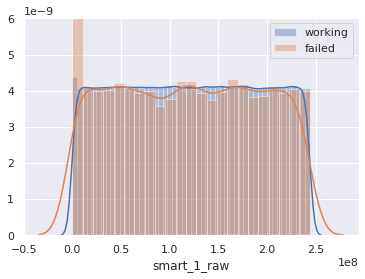

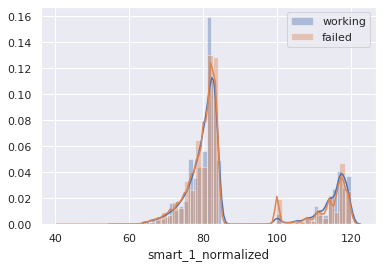

In [24]:
working_df = train[train.serial_number.isin(working_serials.values)]
failed_df = train[train.serial_number.isin(failed_serials.values)]

hist_cols = ['smart_1_raw', 'smart_1_normalized']
# working and failed plots together
for col in hist_cols:
    # get figure and axes for plotting current column
    fig, ax = plt.subplots()
    
    # plot failed and working onto the axes one by one
    data = working_df[col]
    sns.distplot(data[~data.isna()], ax=ax, label='working')
    data = failed_df[col]
    sns.distplot(data[~data.isna()], ax=ax, label='failed')
    plt.legend()
    plt.show()

Looks like this feature (raw) is nearly uniformly distributed across the data set with no visible distinction between failed and working drive behavior. 

Now let's take a few samples drives and see how their error rates changes over time. 

In [25]:
working_drive_sample = np.random.choice(working_serials, size=5, replace = False)
drive = train[train.serial_number == working_drive_sample[0]]

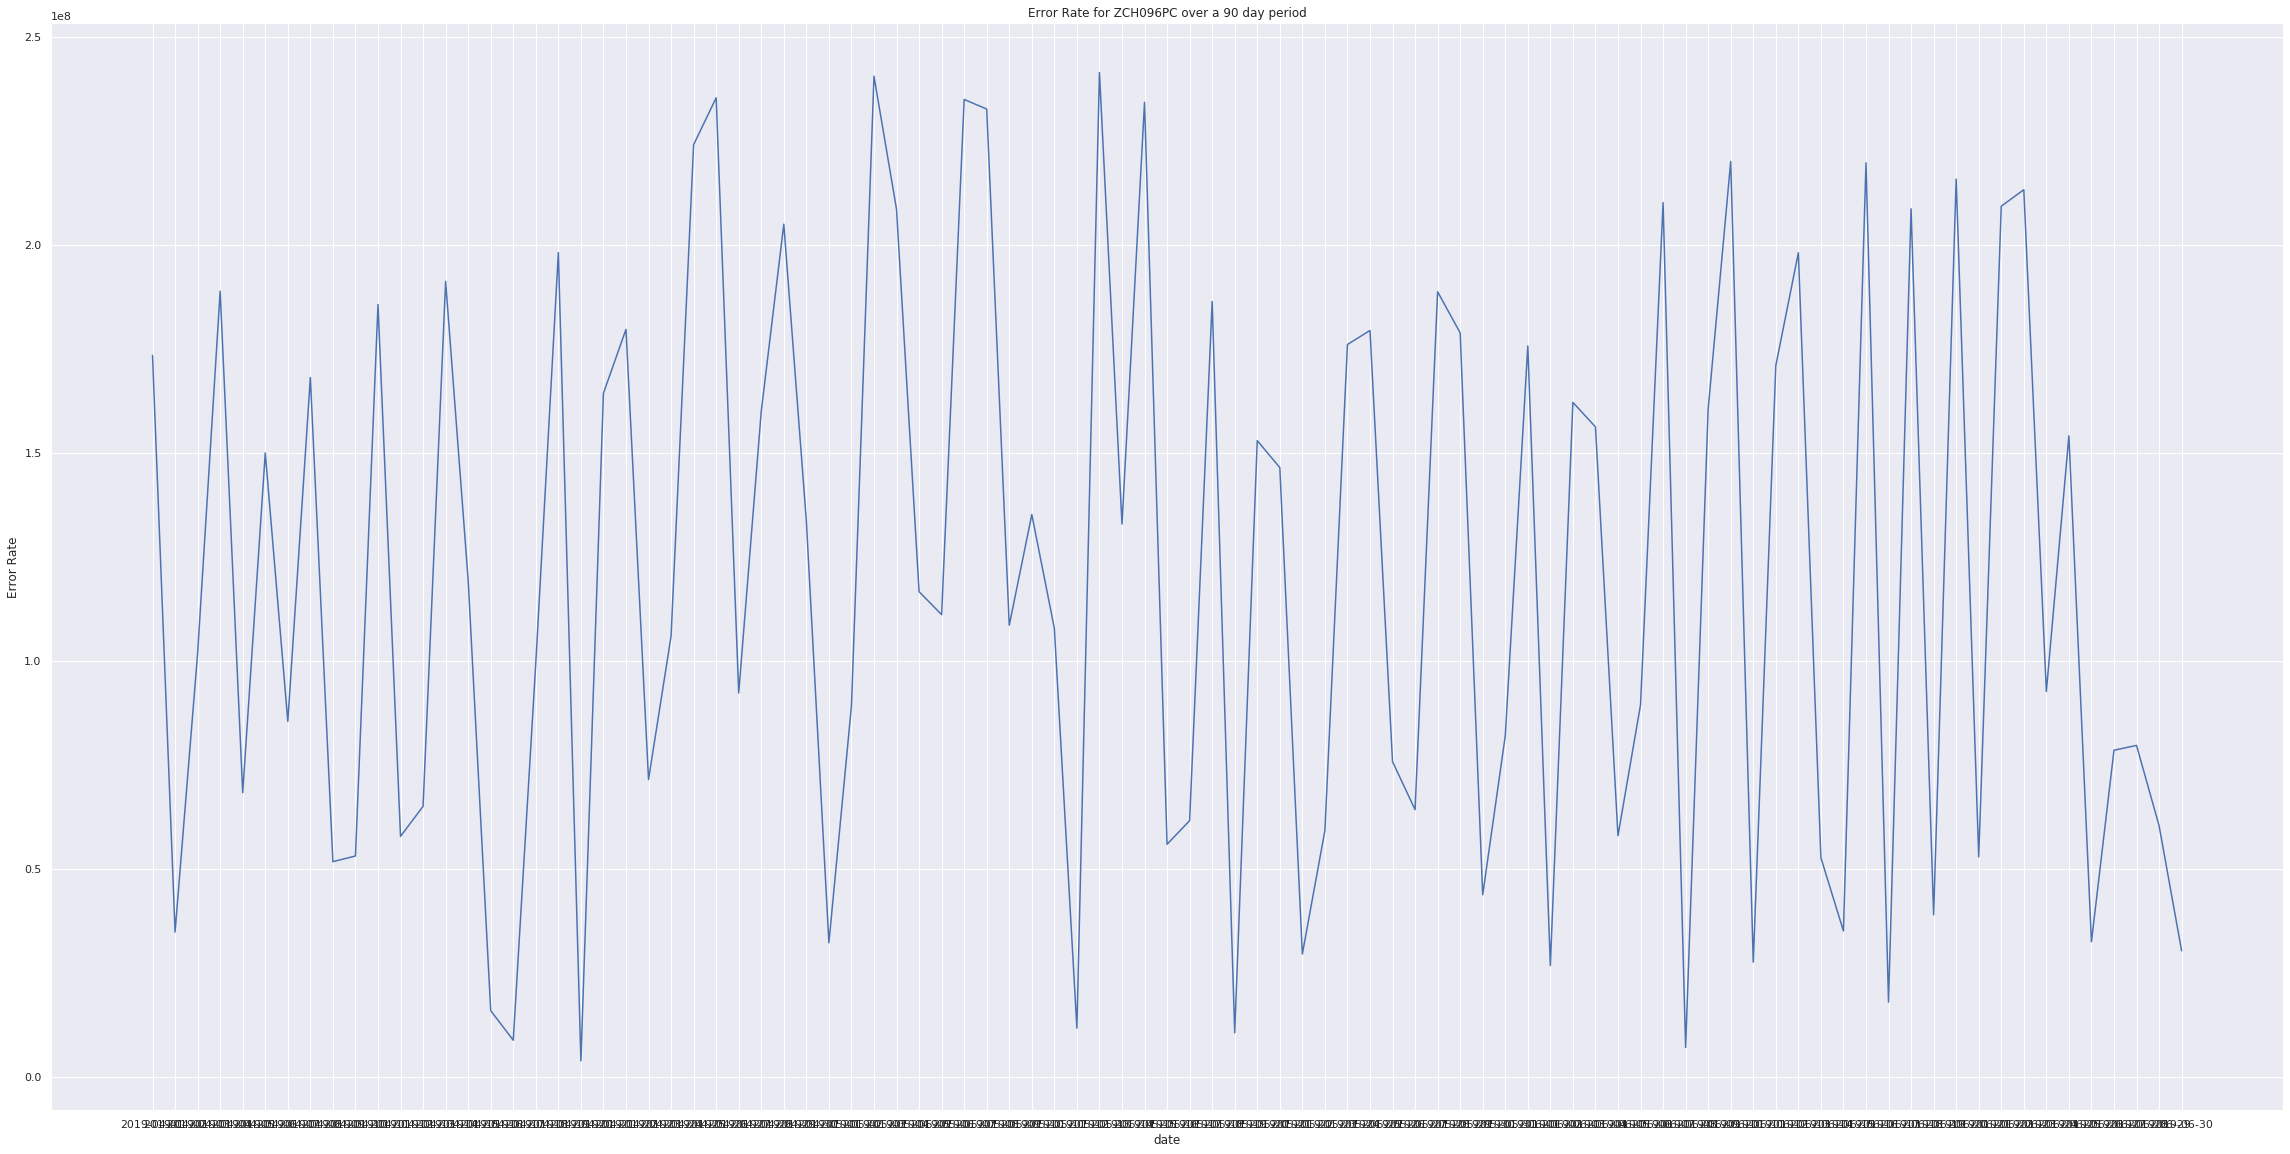

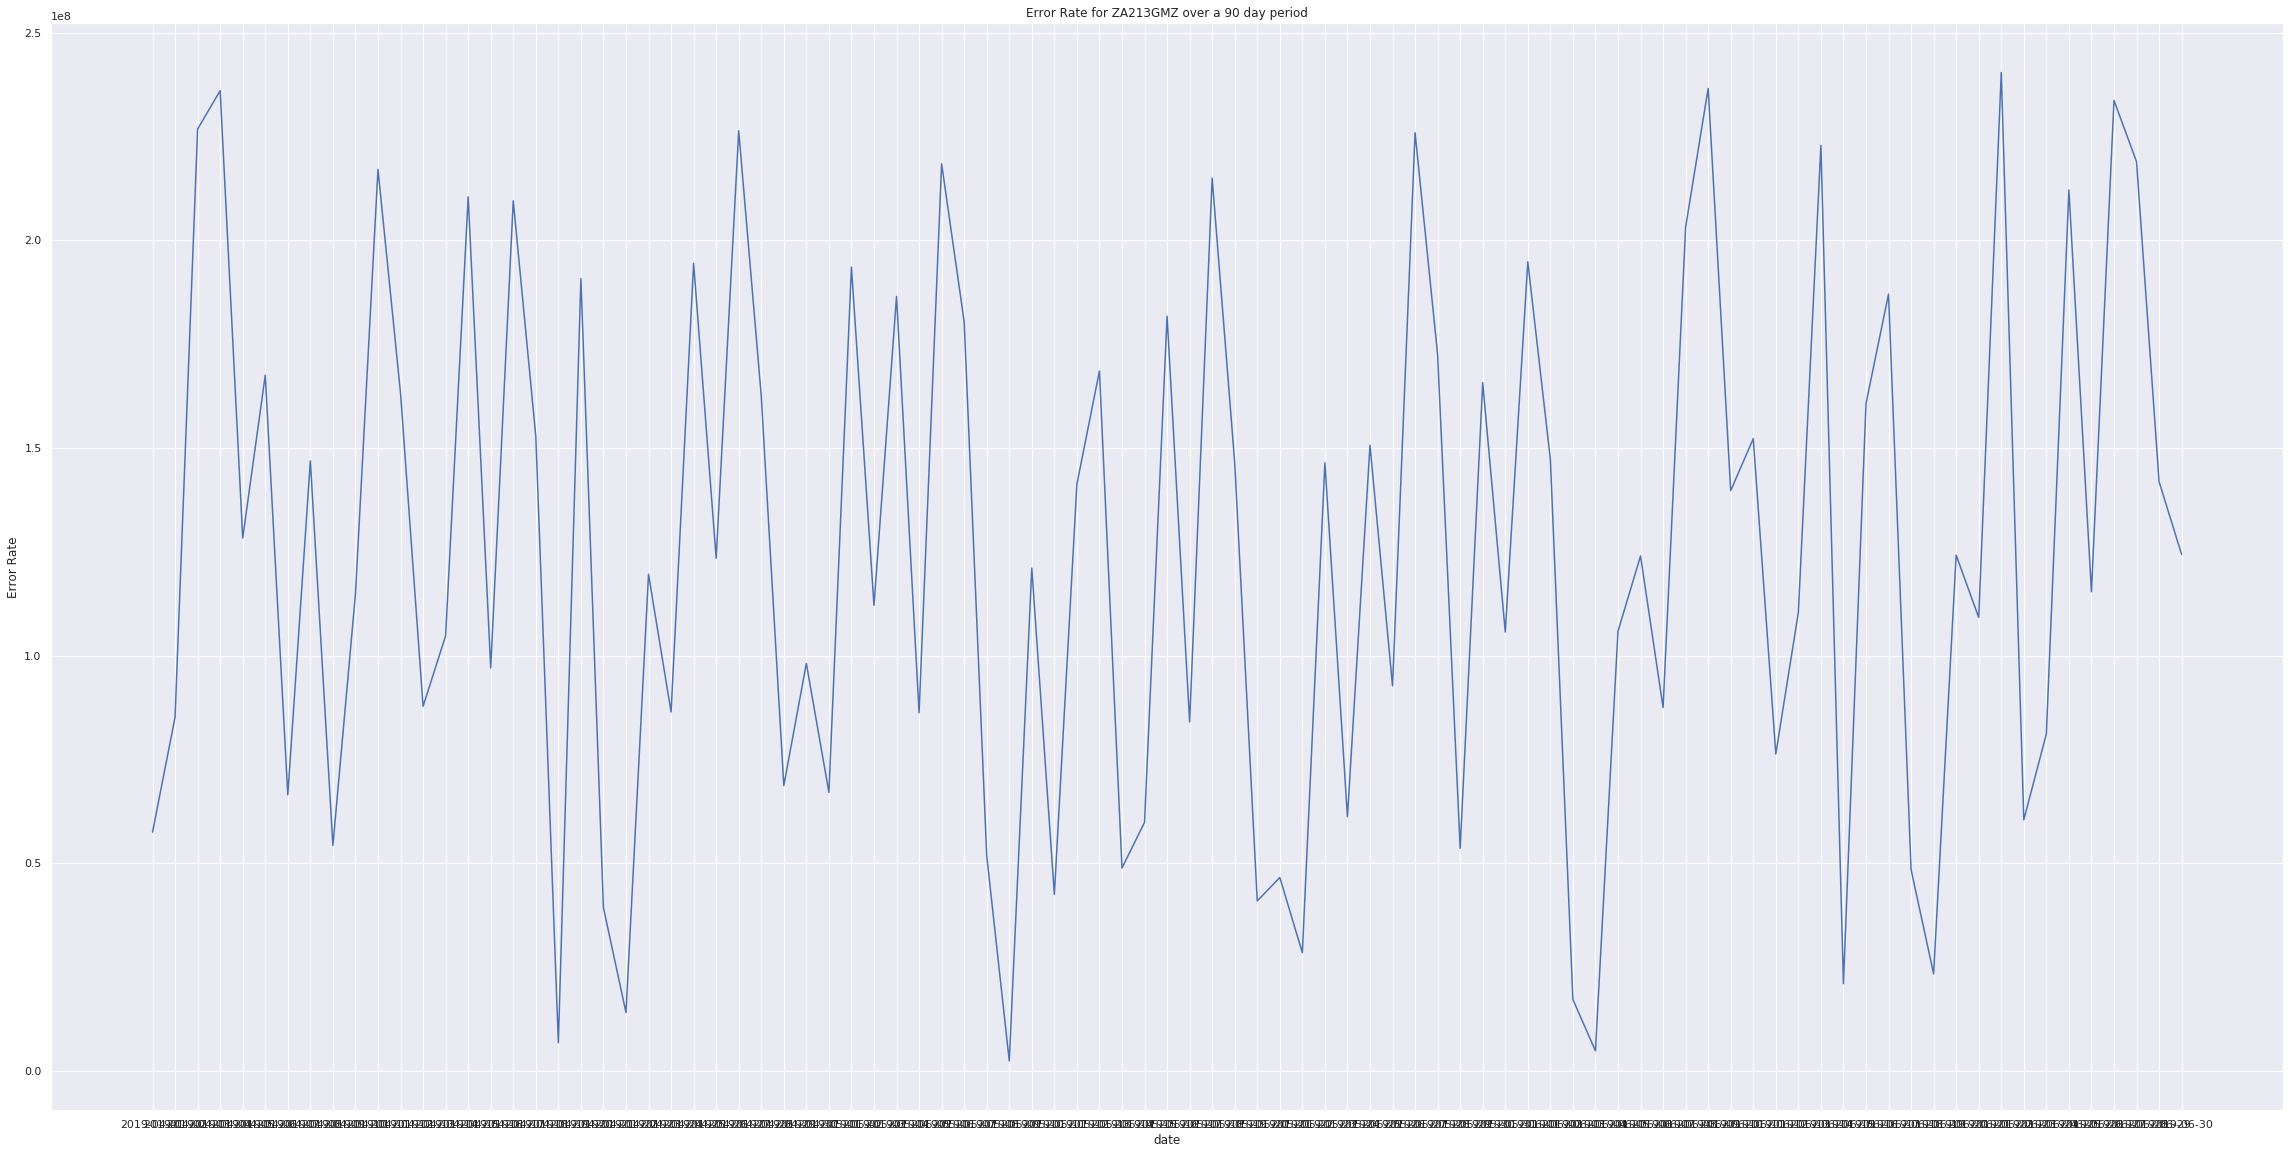

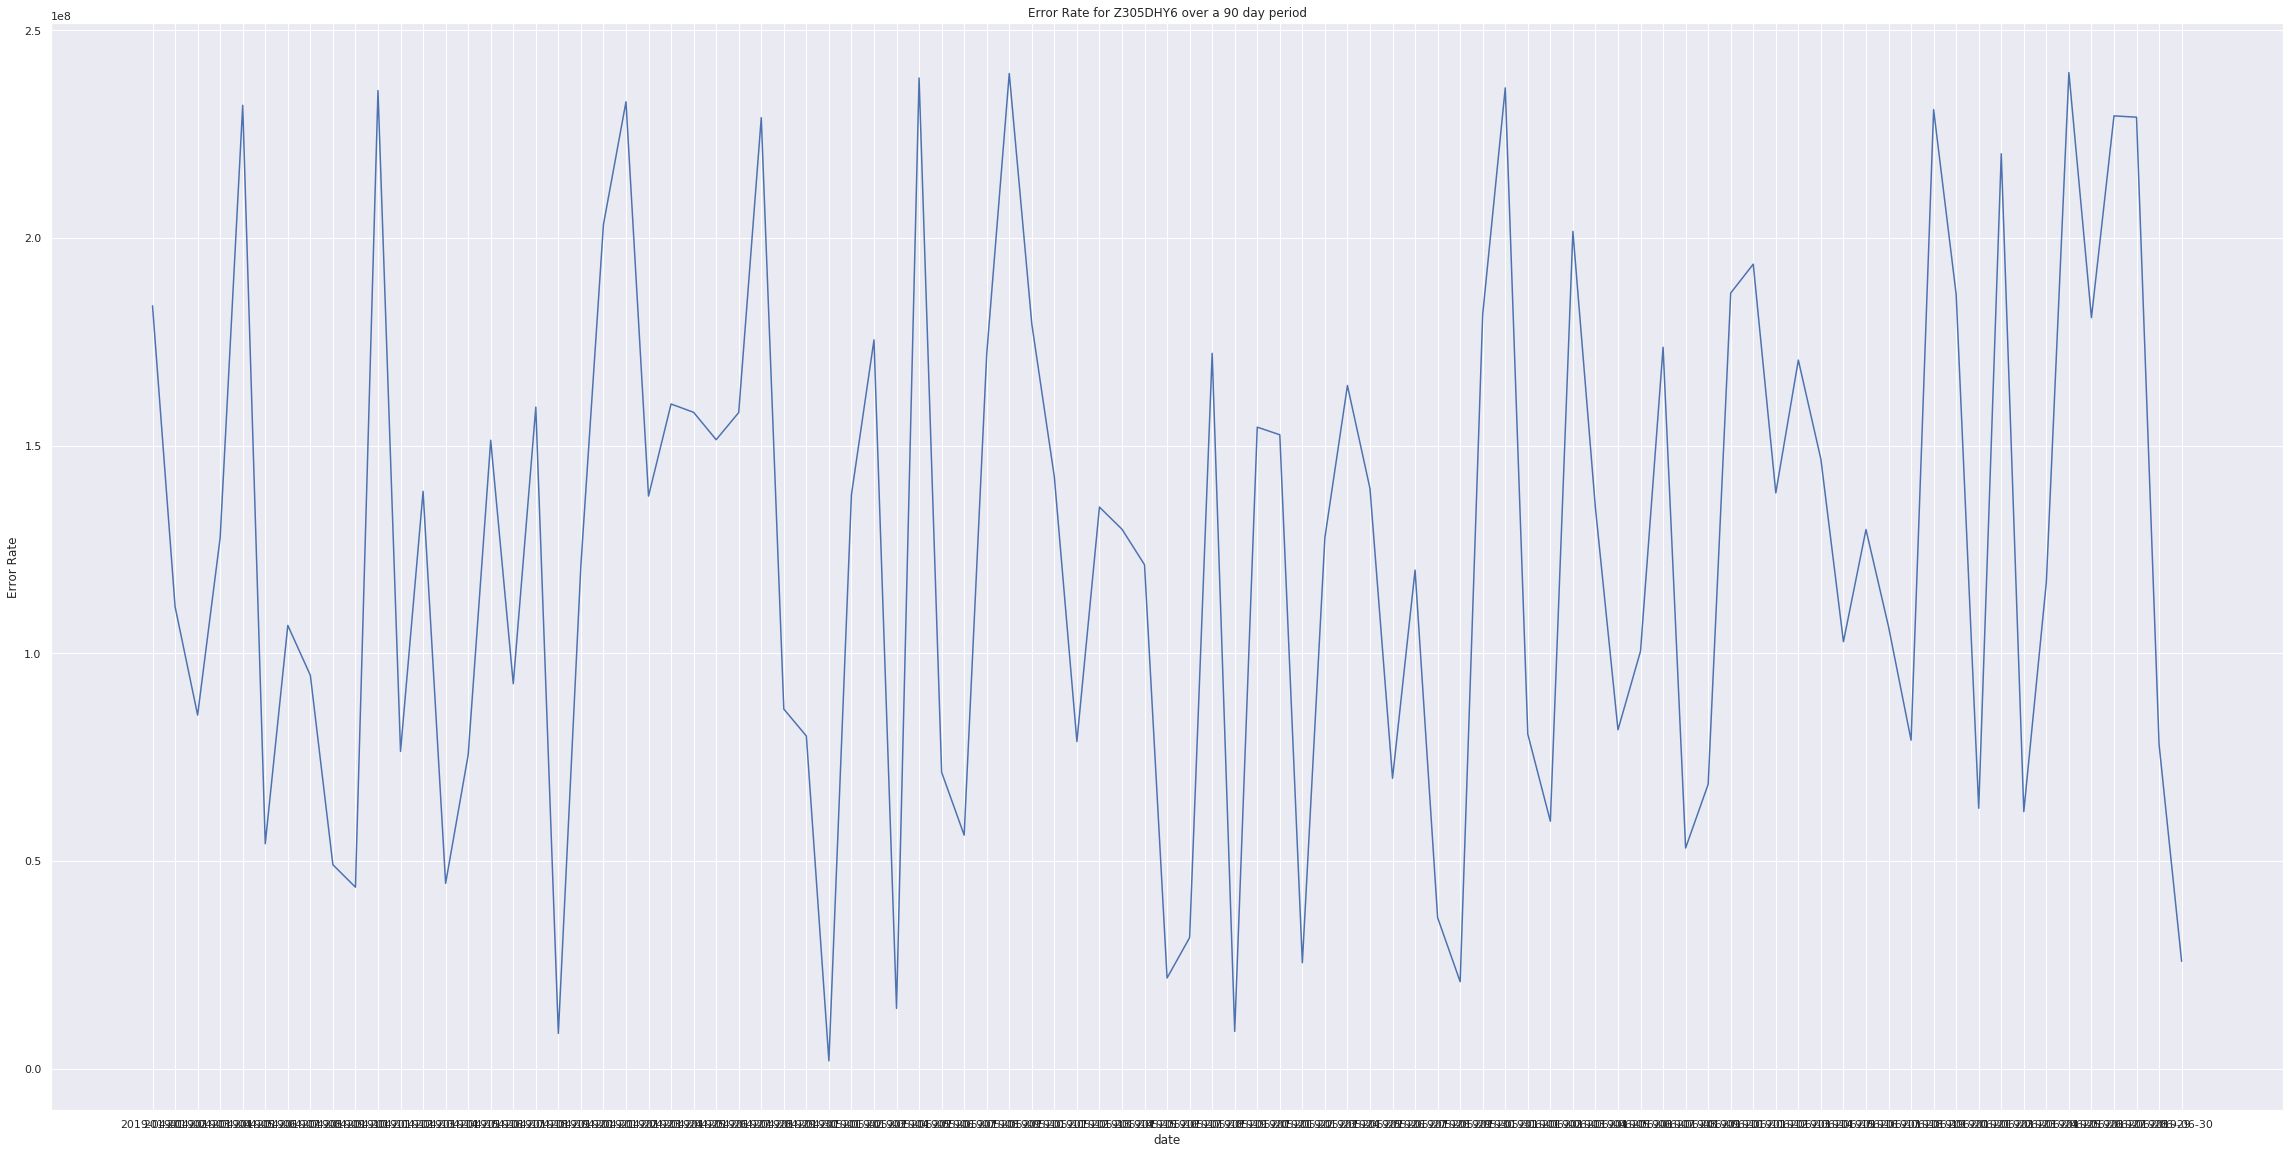

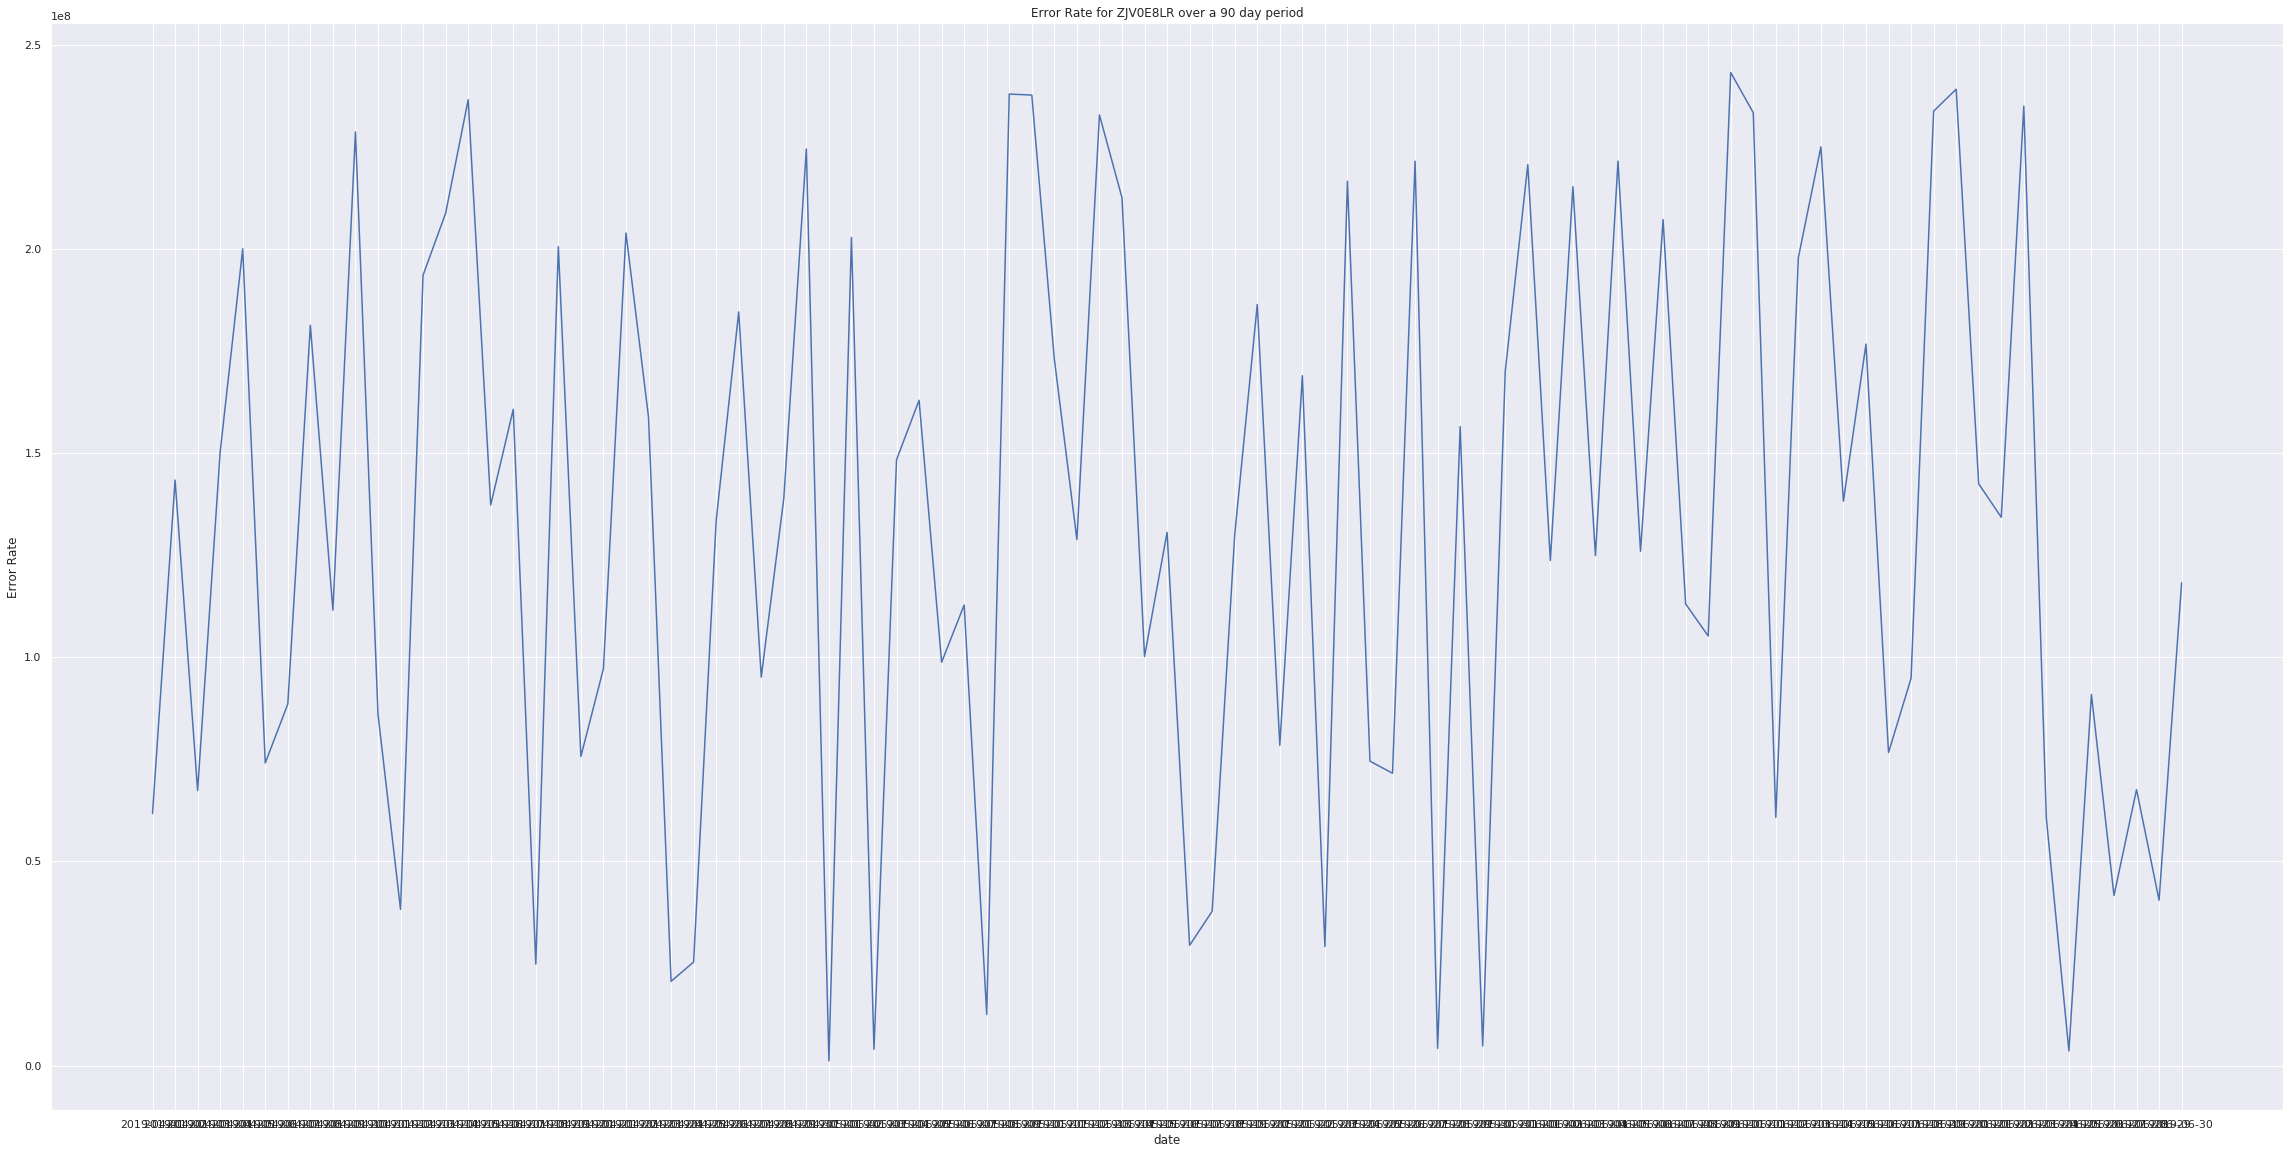

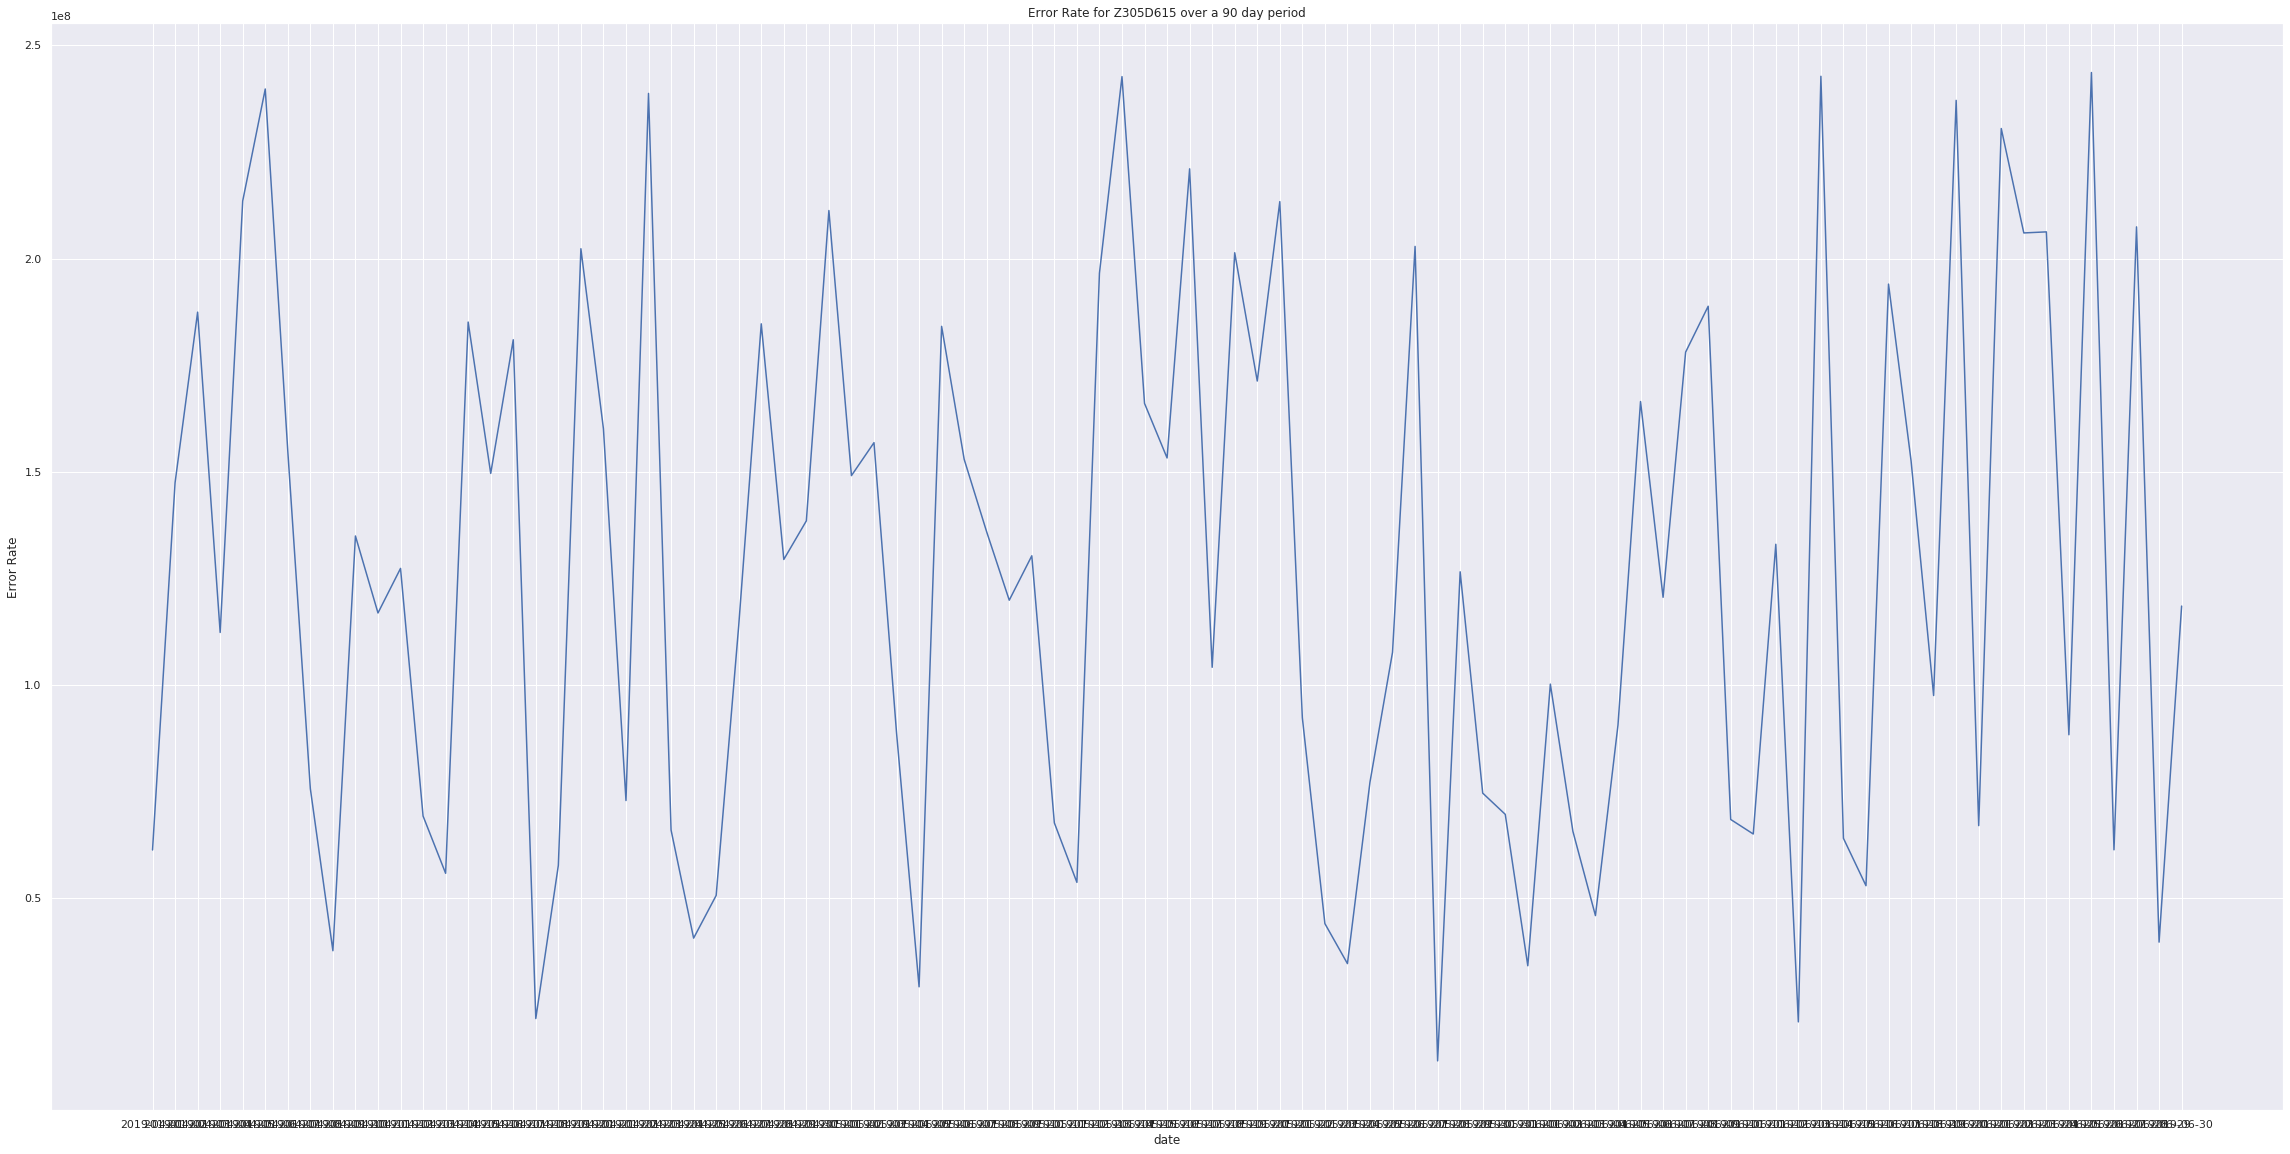

In [26]:
for d in working_drive_sample:
    
    drive = train[train.serial_number == d]
    x = drive.date.compute().values
    y = drive.smart_1_raw.compute().values
    plt.figure(figsize=(40,20))
    plt.plot(x,y)
    plt.xlabel('date')
    plt.ylabel('Error Rate')
    plt.title('Error Rate for {} over a 90 day period'.format(d))
    plt.show()

In [27]:
failed_drive_sample = np.random.choice(failed_serials, size=5, replace = False)
failed_drive_sample

array(['ZJV2ECQC', 'ZCH08BQ9', 'S2ZYJ9DDB26411', 'ZCH08BPM', 'ZCH0BN33'],
      dtype=object)

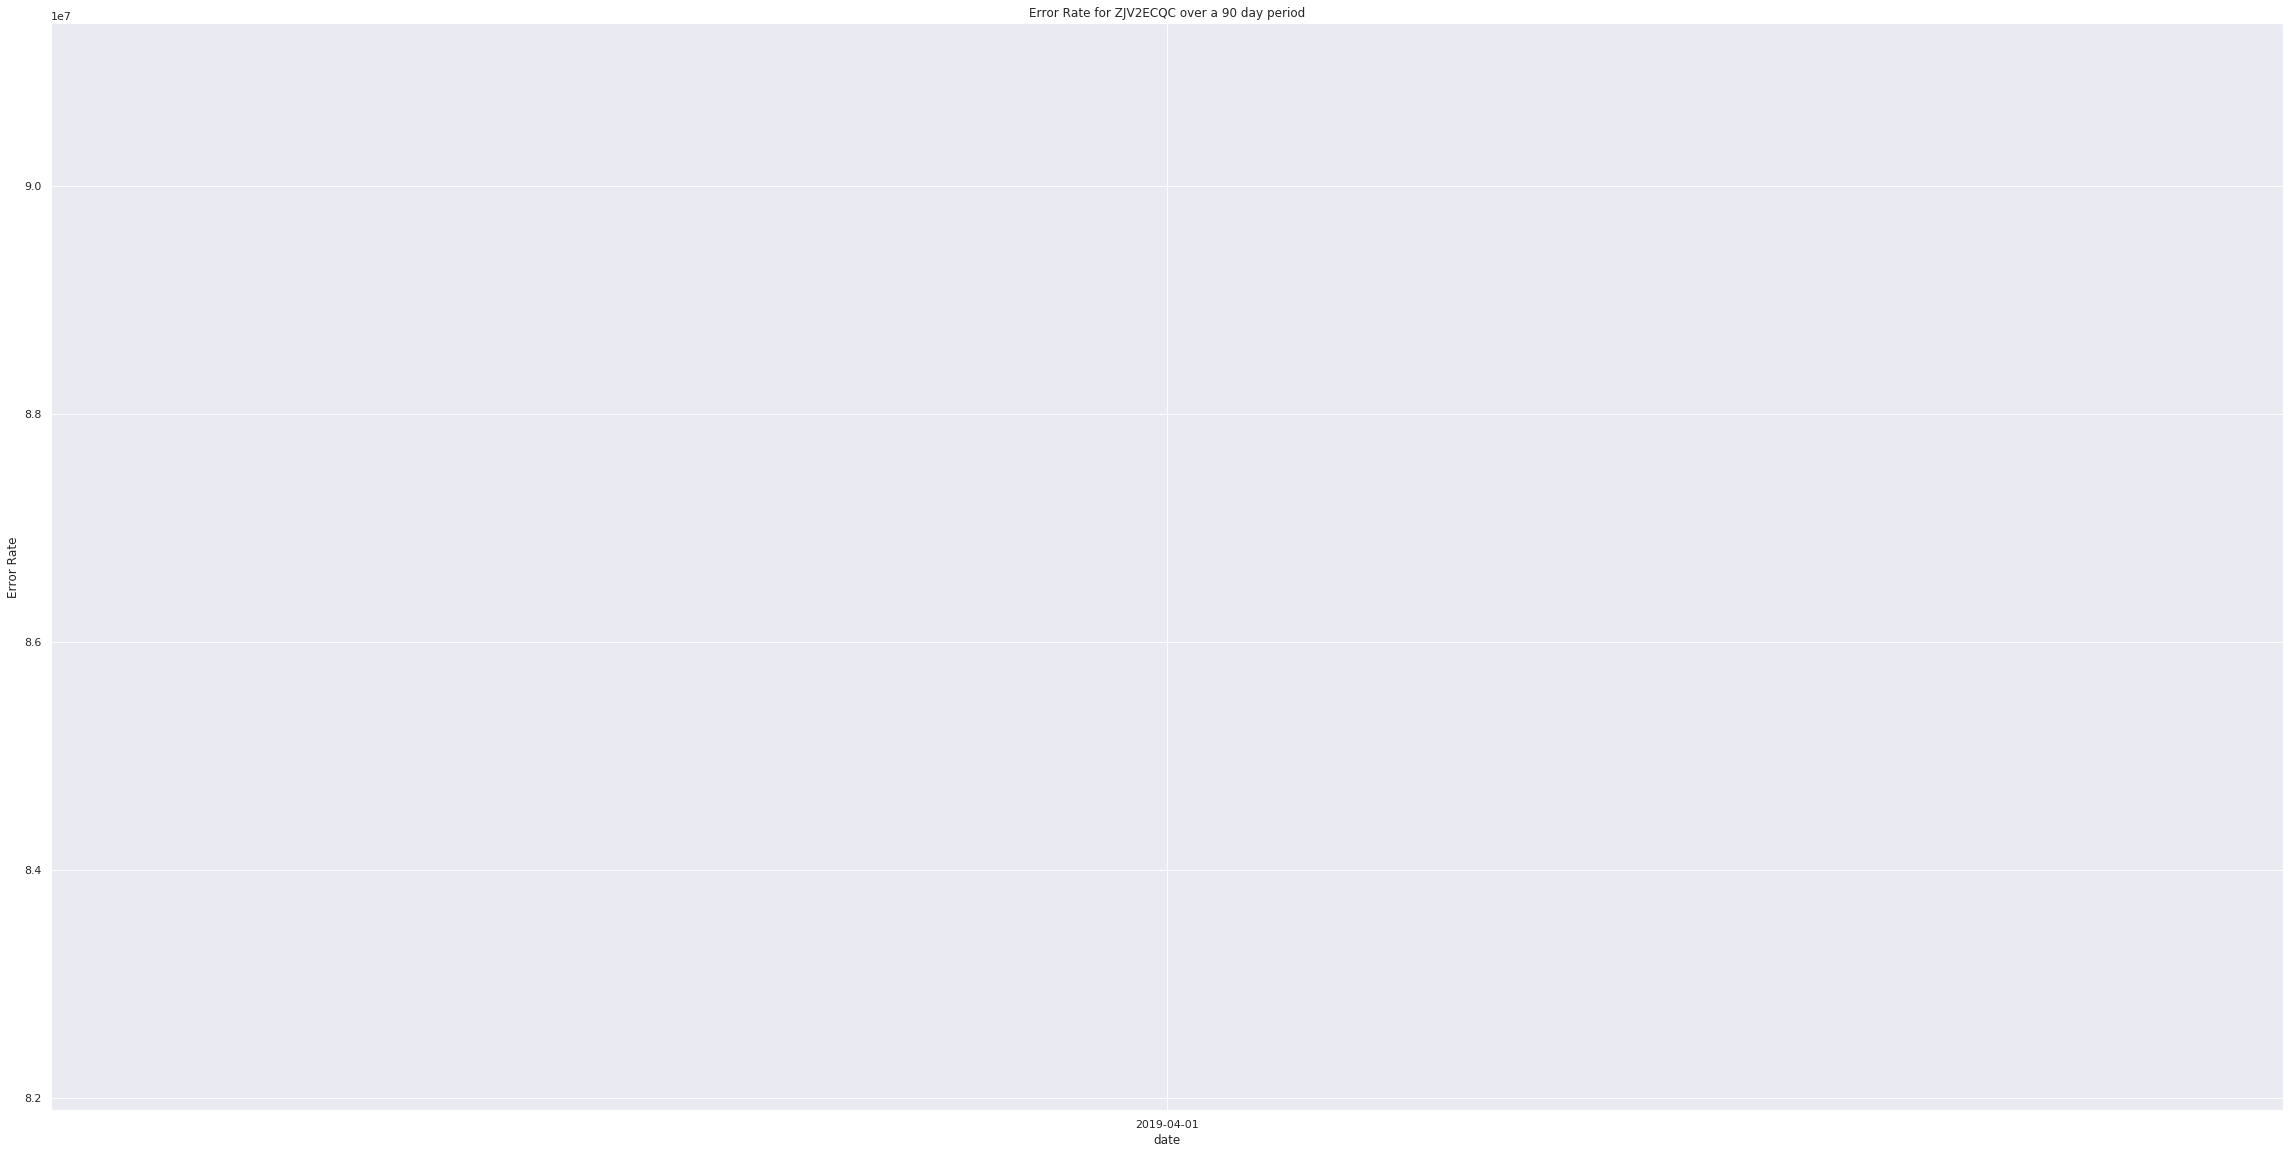

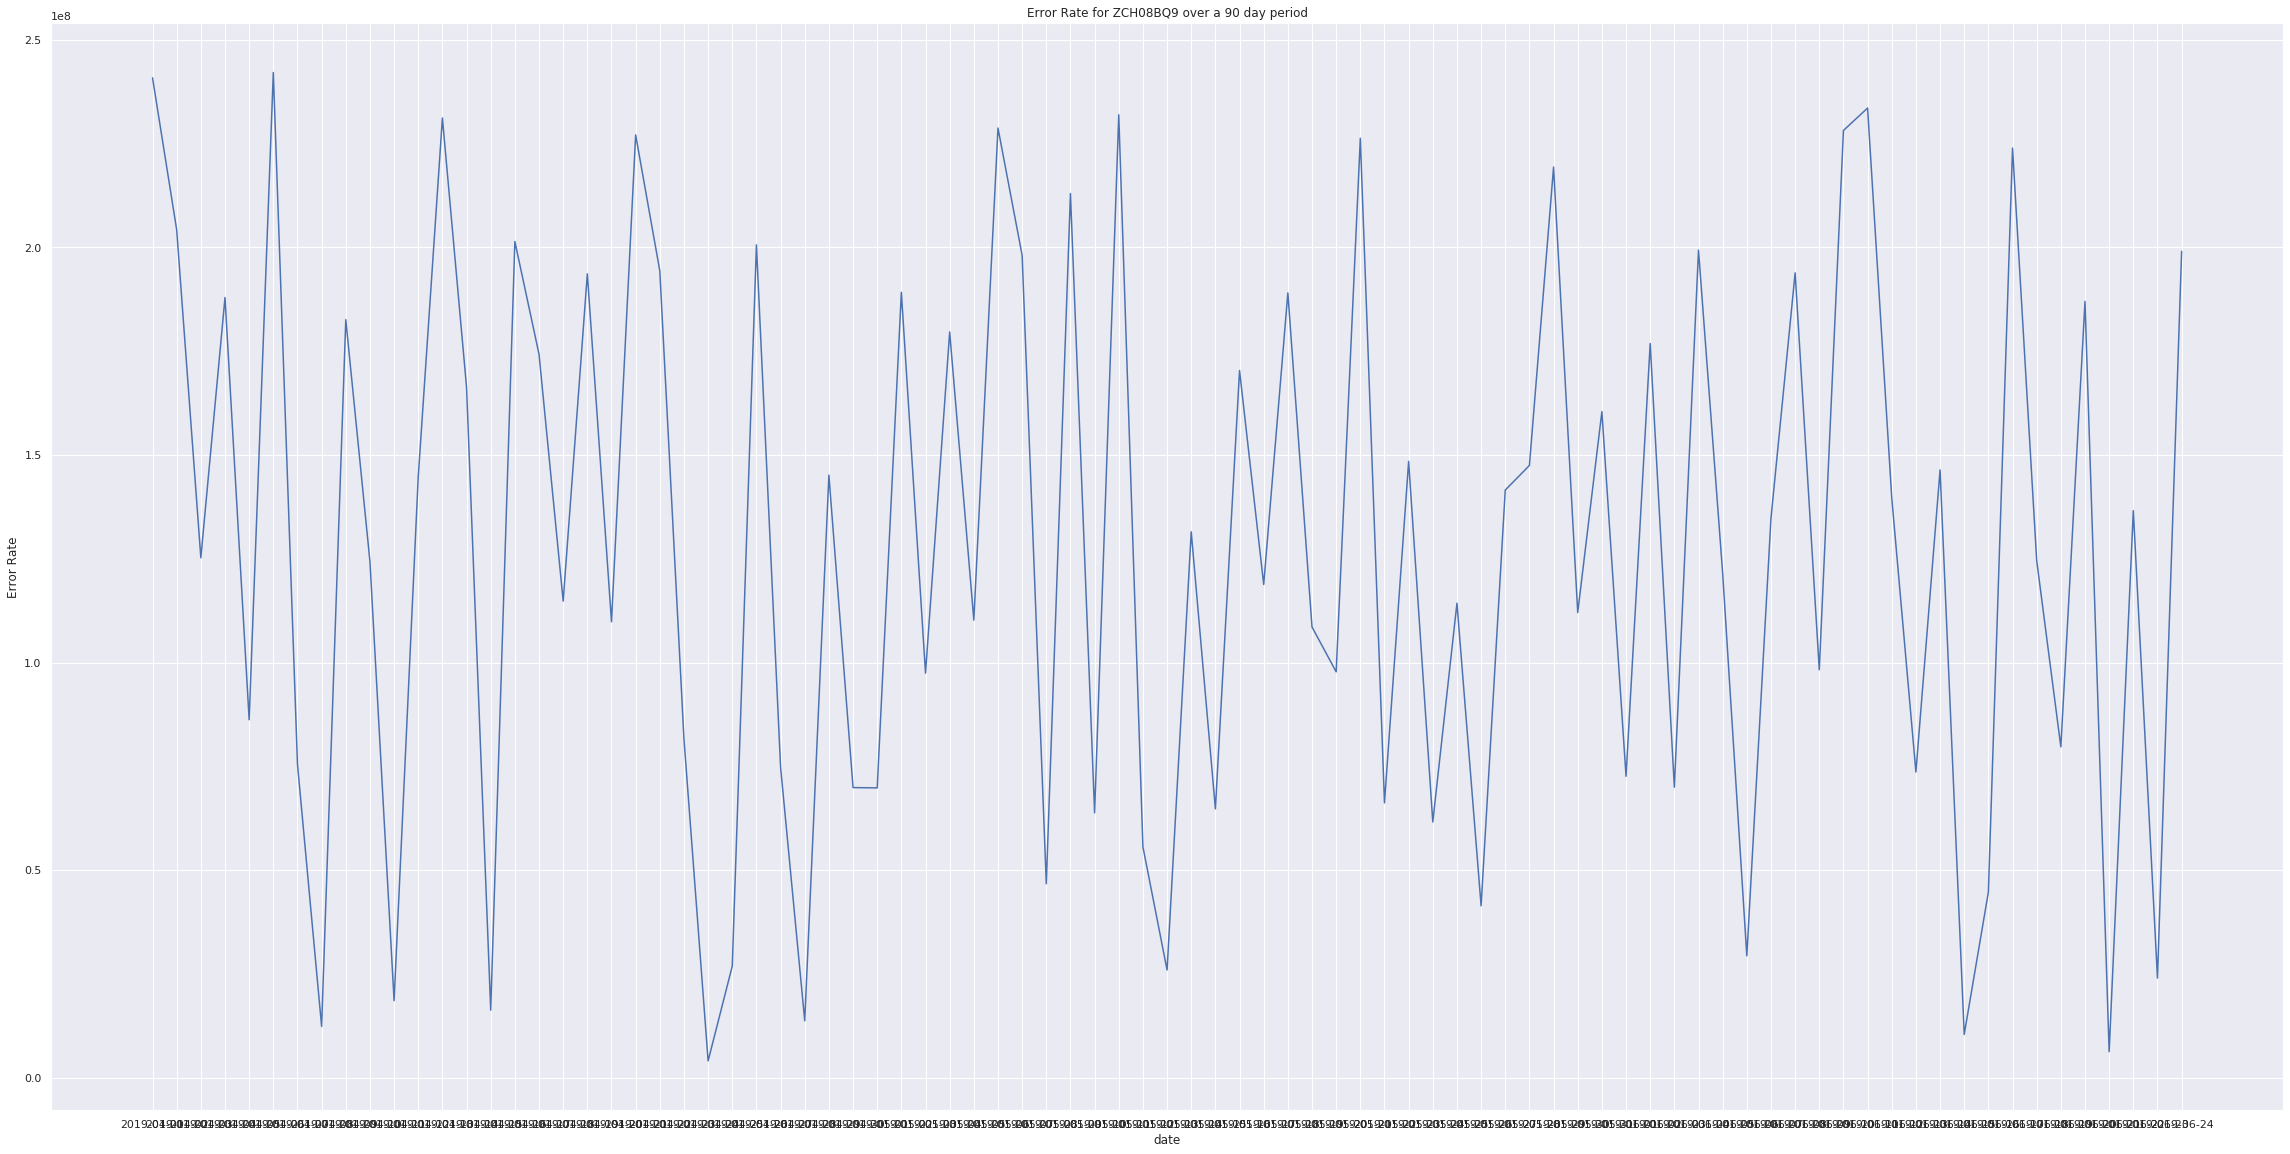

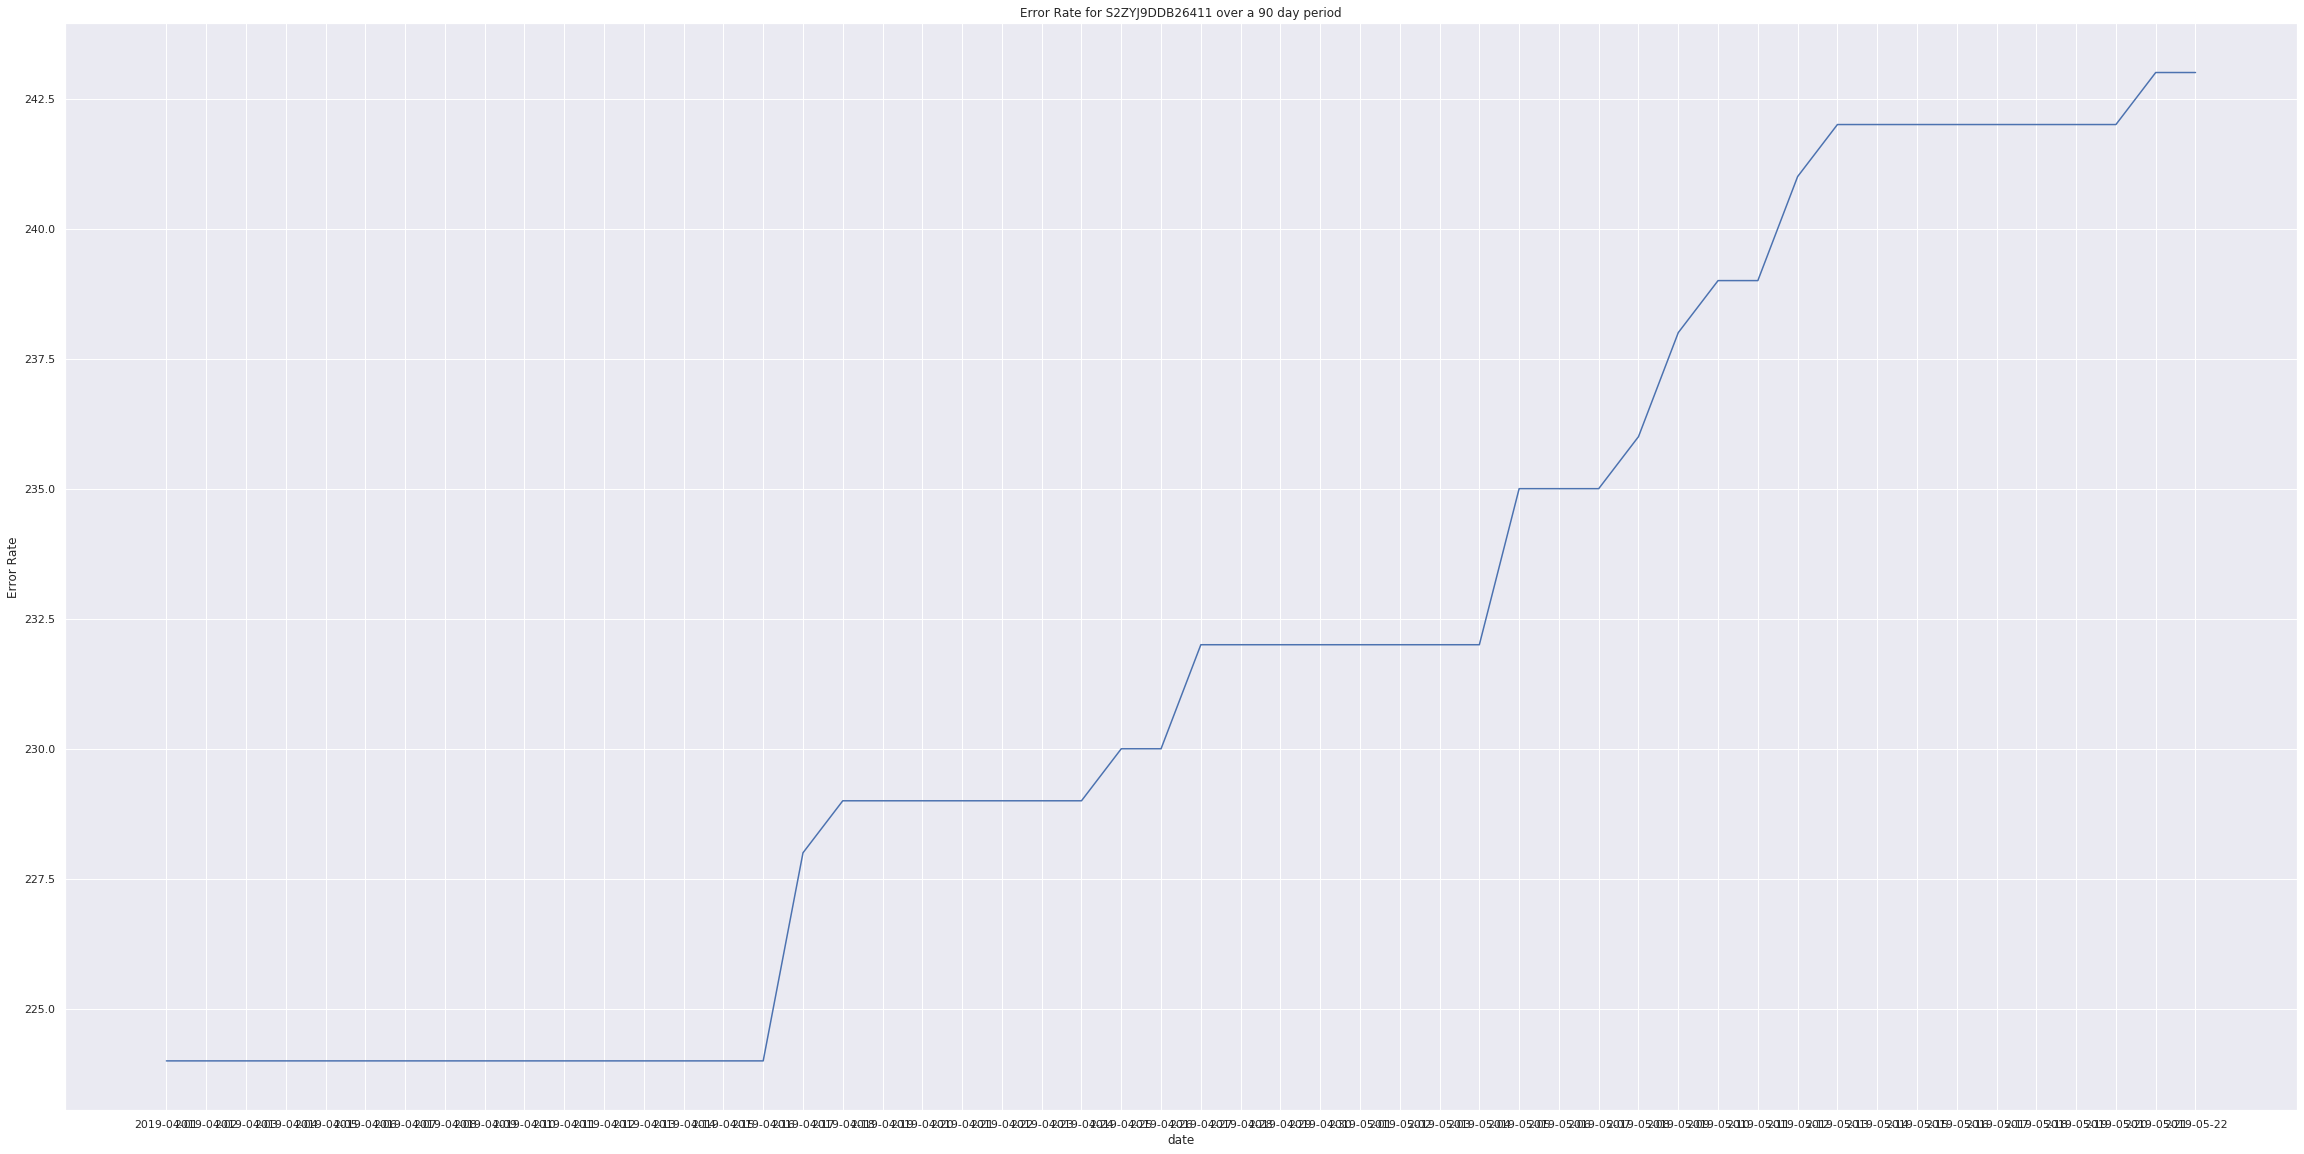

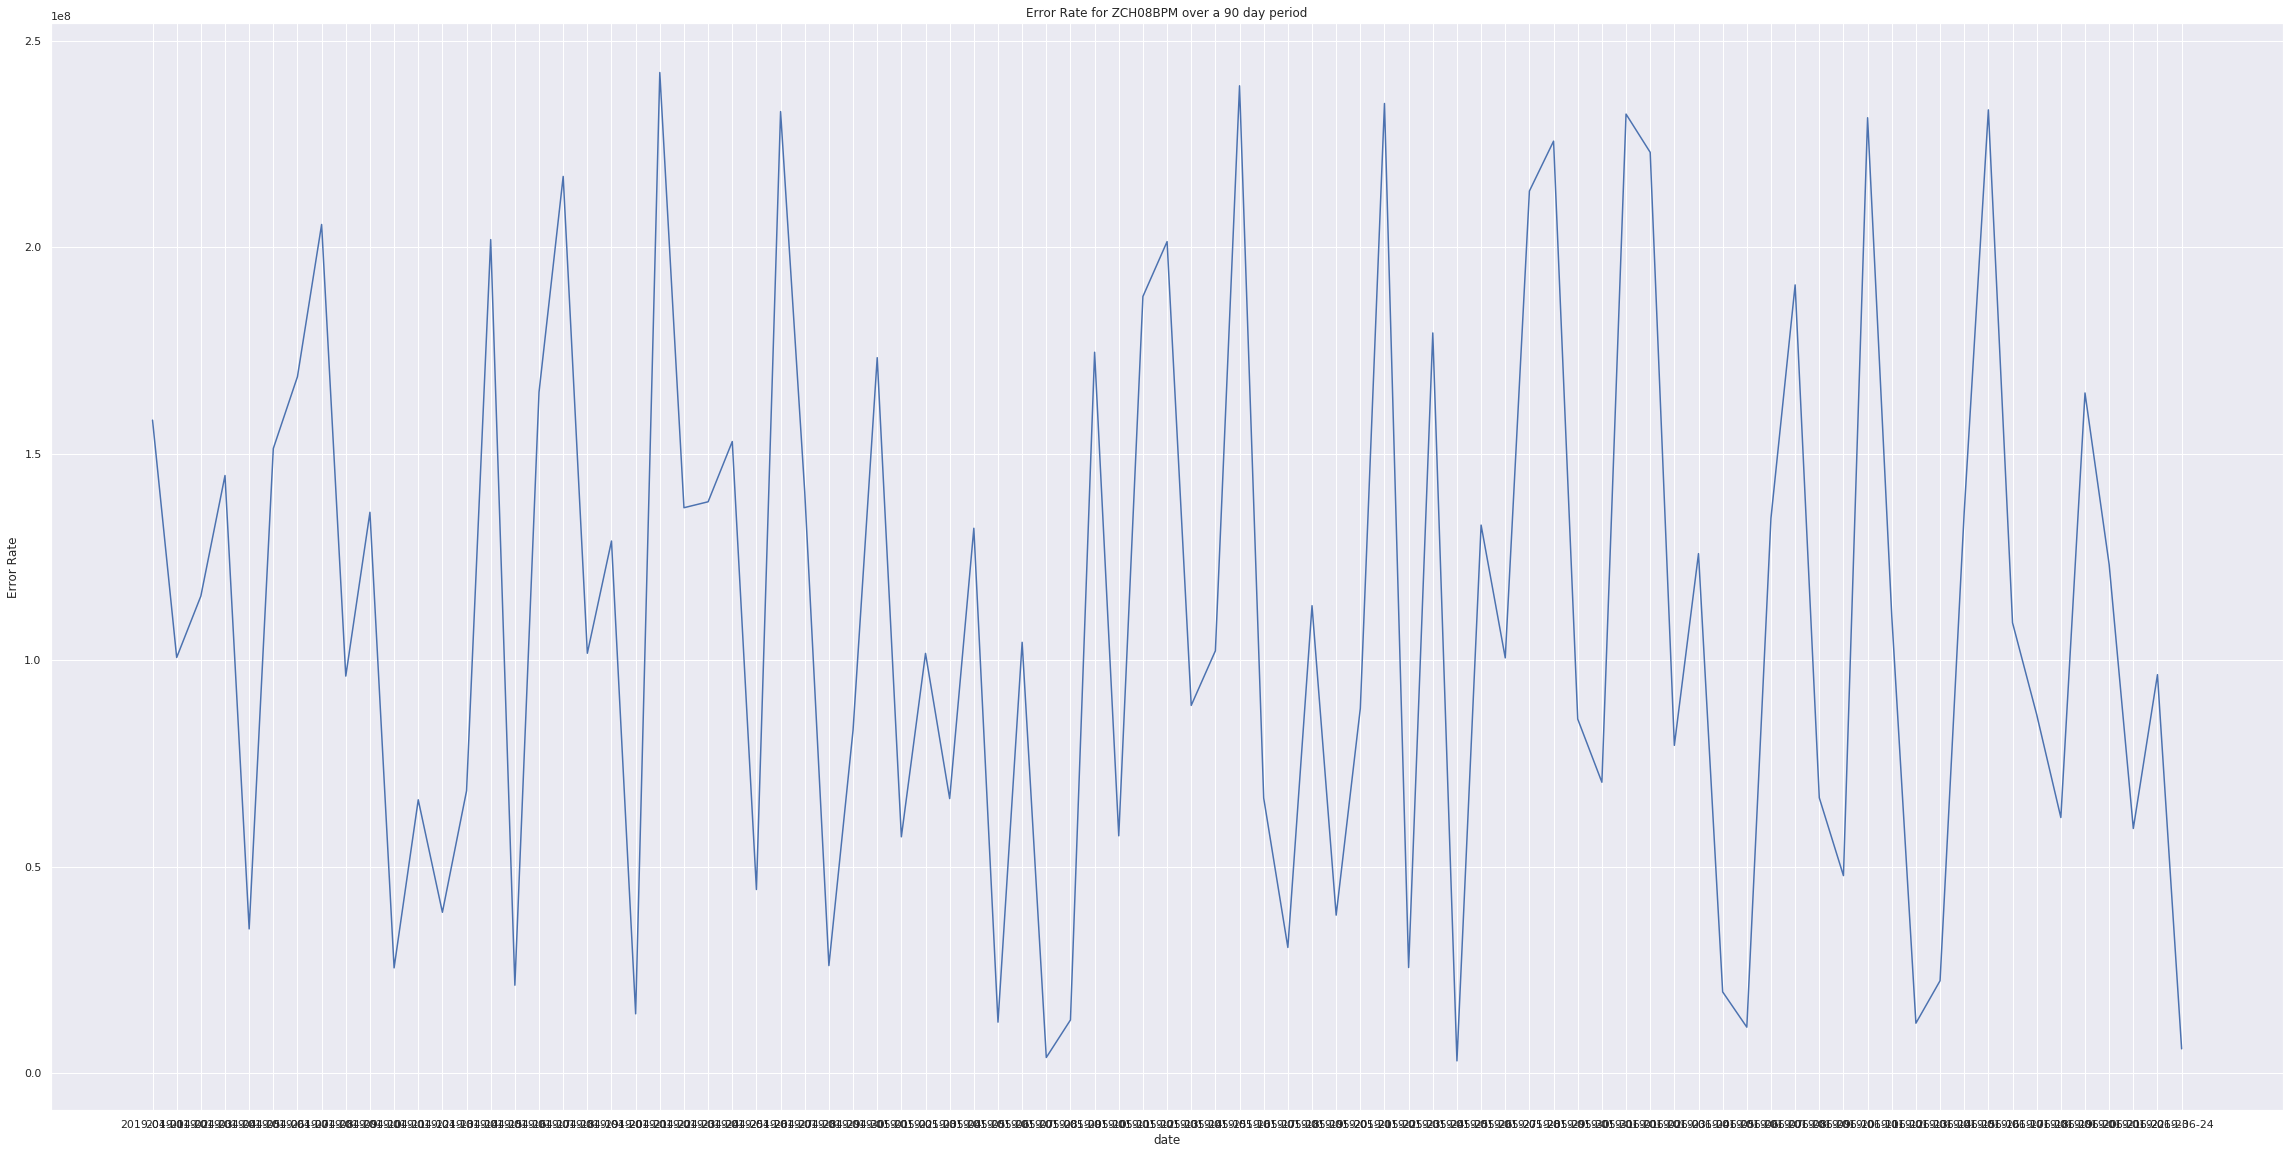

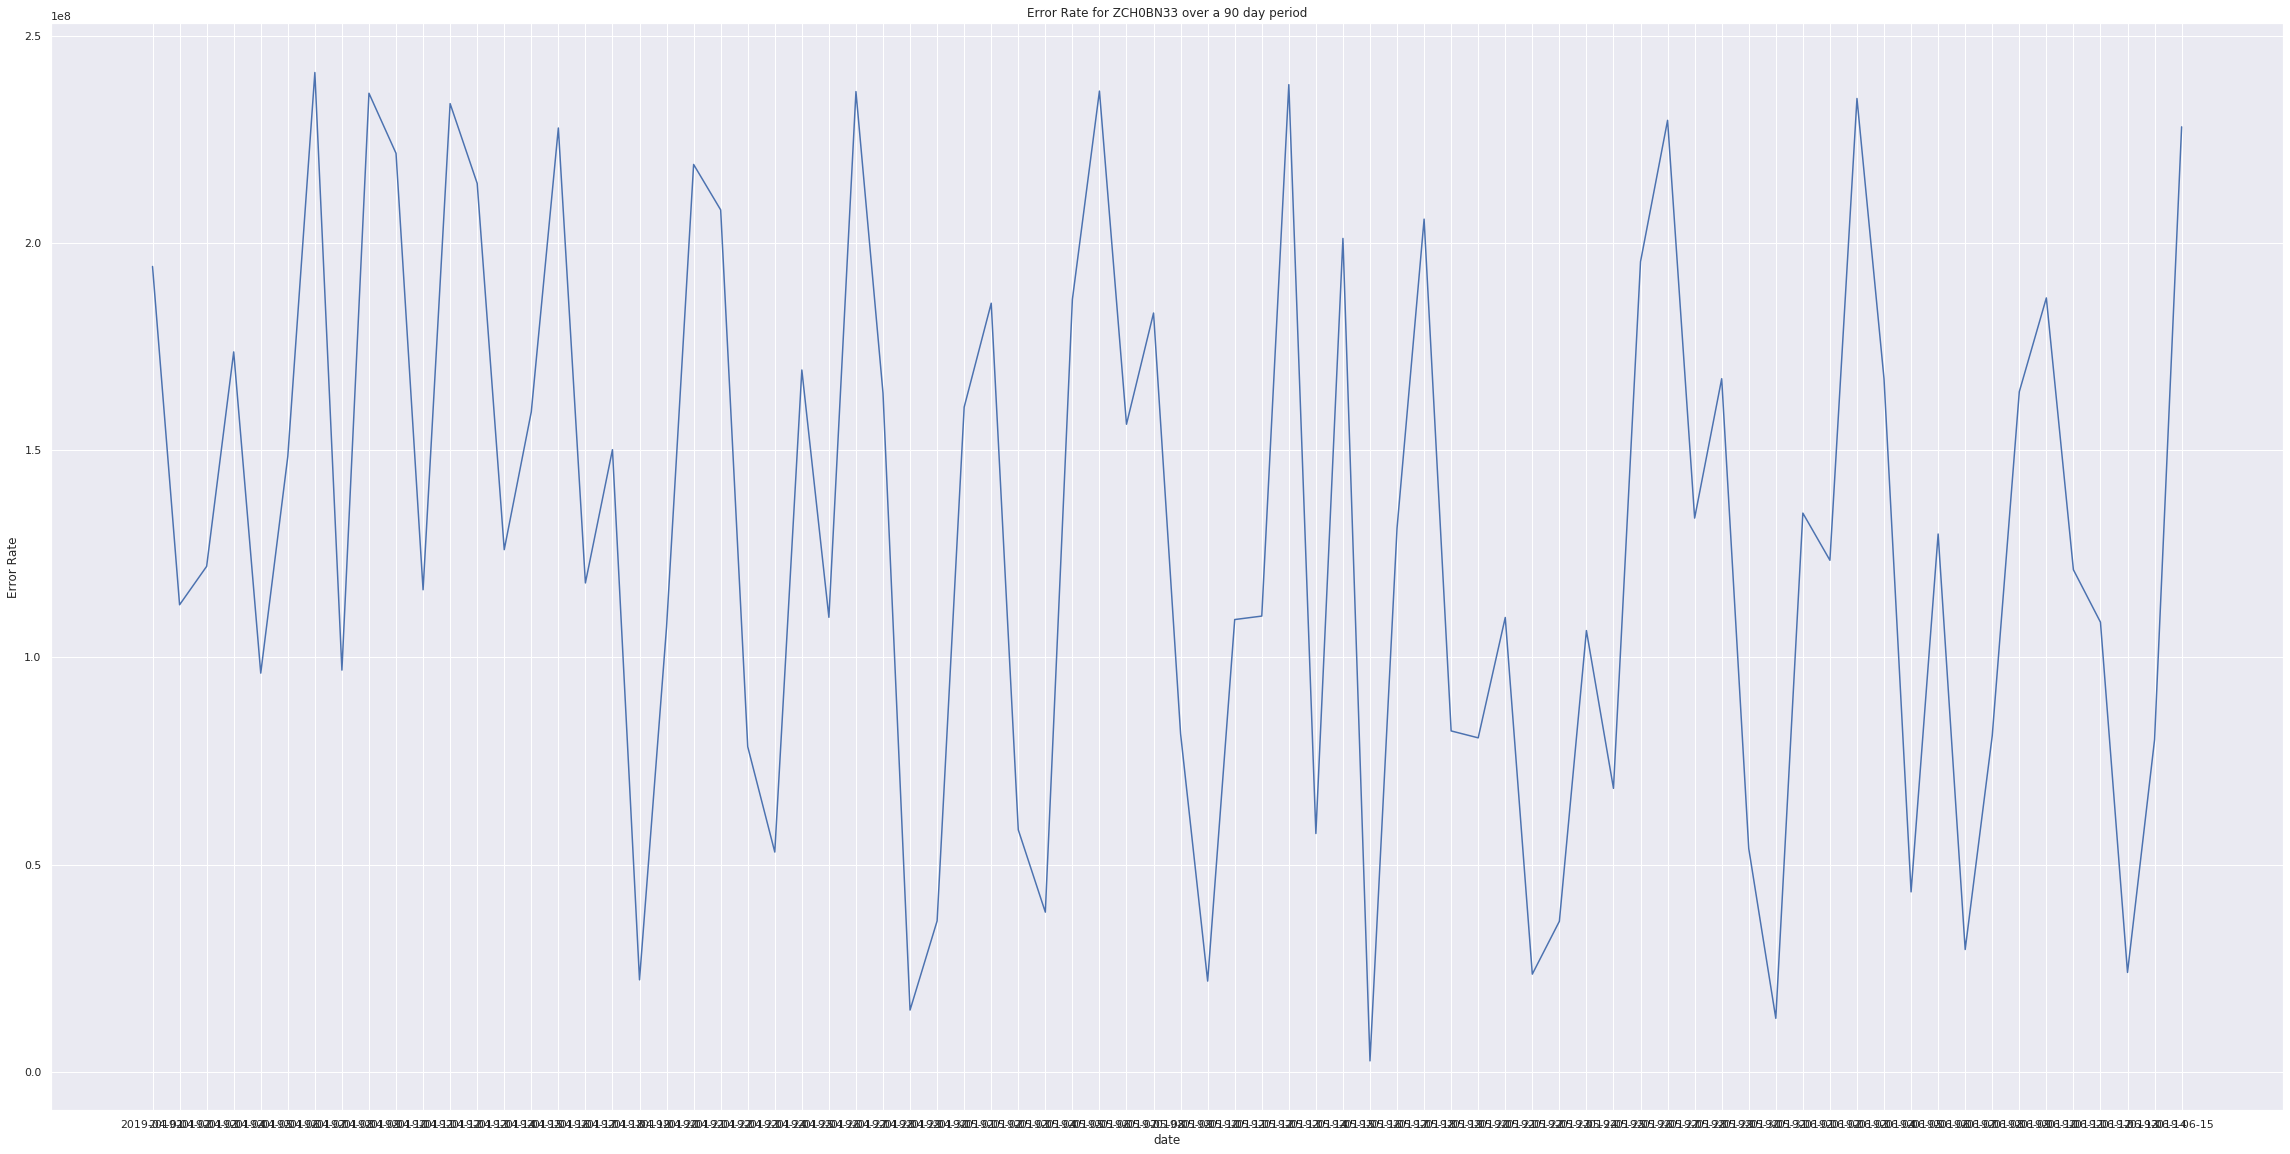

In [28]:
for d in failed_drive_sample:
    
    drive = train[train.serial_number == d]
    x = drive.date.compute().values
    y = drive.smart_1_raw.compute().values
    plt.figure(figsize=(40,20))
    plt.plot(x,y)
    plt.xlabel('date')
    plt.ylabel('Error Rate')
    plt.title('Error Rate for {} over a 90 day period'.format(d))
    plt.show()

In both cases, it looks like the signals are quite noisy and fluctuate dramatically day to day. The only thing that stands out here are those failed drives that only have a couple data points during this quarter. But that won't be too helpful in predicting future error rates given our 6 day data window.  

Perhaps there are useful differences or correlations with some of the other features that we can see. 

In [29]:
train = train.compute()

In [30]:
w = train[train.serial_number.isin(working_serials)].groupby(by='serial_number').mean().mean()
f = train[train.serial_number.isin(failed_serials)].groupby(by='serial_number').mean().mean()
delta = w-f
ws = train[train.serial_number.isin(working_serials)].groupby(by='serial_number').std().mean()
fs = train[train.serial_number.isin(failed_serials)].groupby(by='serial_number').std().mean()
deltas = ws-fs
stats_df = pd.DataFrame([w,f,delta,ws,fs,deltas], index=['mean_working','mean_failed','mean_delta','std_working','std_failed', 'std_delta'])
stats_df

,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,smart_187_raw,smart_188_raw,...,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
mean_working,8.719081e+12,0.000000,1.218952e+08,8.313391,2.003288e+09,17753.941909,0.0,-42.822850,0.125950,1.294310e+08,...,99.999986,13.919487,71.418258,92.851186,28.581742,100.000000,100.000000,99.992789,99.993148,99.993148
mean_failed,9.182549e+12,0.099920,1.162084e+08,983.742969,1.234291e+09,15616.590143,0.0,-56.374033,12.908849,4.094376e+08,...,99.999575,-13.410711,71.268764,95.986913,29.326931,102.187263,102.366227,96.577381,96.577381,96.577381
mean_delta,-4.634680e+11,-0.099920,5.686815e+06,-975.429578,7.689967e+08,2137.351765,0.0,13.551182,-12.782899,-2.800066e+08,...,0.000412,27.330198,0.149494,-3.135727,-0.745188,-2.187263,-2.366227,3.415408,3.415767,3.415767
std_working,0.000000e+00,0.000000,7.006229e+07,1.309563,3.120649e+08,628.755207,0.0,0.000000,0.002748,7.484061e+06,...,0.000045,0.006300,1.109420,0.127847,1.109420,0.000000,0.000000,0.000327,0.000000,0.000000
std_failed,0.000000e+00,0.203519,6.829153e+07,257.271233,2.549932e+08,324.167388,0.0,0.070937,48.248491,1.244564e+08,...,0.001254,0.057664,1.058724,0.039657,1.061718,0.275992,0.017062,0.125374,0.125374,0.125374
std_delta,0.000000e+00,-0.203519,1.770766e+06,-255.961670,5.707162e+07,304.587819,0.0,-0.070937,-48.245743,-1.169723e+08,...,-0.001209,-0.051364,0.050695,0.088189,0.047702,-0.275992,-0.017062,-0.125047,-0.125374,-0.125374


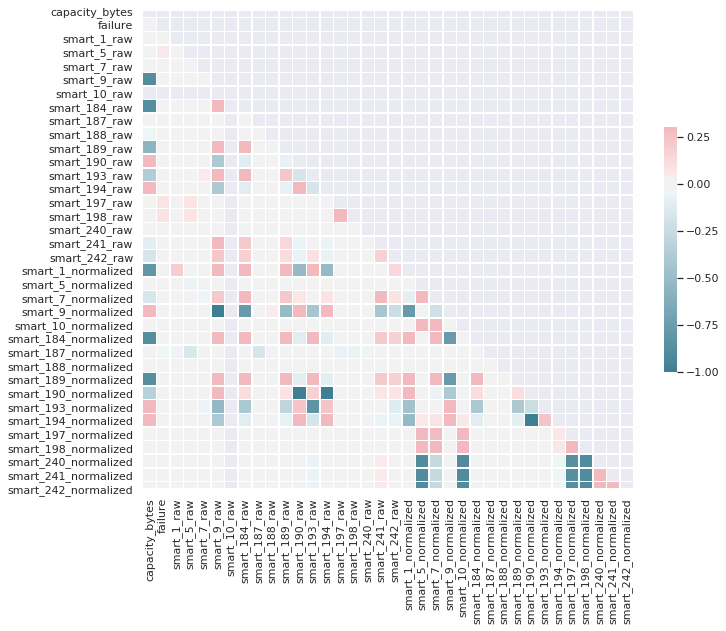

In [31]:
# Compute the correlation matrix
corr = train.corr()
sns.set()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Well, it looks like smart_1_raw isn't actually correlated with any other feature besides the its normalized counterpart. We may need to find some non-linear relationship between smart_1_raw and the other features if we are going o find a good model to help us solve this problem. 

# 4. Naive Models and Baselines

Here we are going to produce some extremely simple models as baselines. Specifically, we are going to predict our output to be the previous day's value. We will also create a second model that predicts the value to be the average value for the last 6 days. Any model, to be considered performant, must outperform the best of these two naive approaches and score a lower MSLE.

Due the the large value of our target variable, we will use the Mean Squared Logarithmic Error (MSLE) as our performance criteria. This error metric encodes the ratio between the ground truth and predicted values.  

#### Previous day 

In [32]:
def y_y_pred(x):
    y_pred = list(x.values[5:-1])
    y = list(x.values[6:])
    return y, y_pred

In [33]:
f = train.groupby('serial_number').smart_1_raw.apply(y_y_pred)
f.head()

serial_number
S2X67QW1          ([108307210.0, 111598860.0, 114863330.0, 11824...
S2ZYJ9DDB26411    ([224.0, 224.0, 224.0, 224.0, 224.0, 224.0, 22...
S2ZYJ9DFA03954    ([14.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15...
S2ZYJ9GF302340    ([1204.0, 1204.0, 1208.0, 1208.0, 1212.0, 1215...
S2ZYJ9GF302349                     ([552.0, 552.0], [552.0, 552.0])
Name: smart_1_raw, dtype: object

In [34]:
y = []
y_pred = []
for i in f:
    y.append(i[0])
    y_pred.append(i[1])
    
y = [item for sublist in y for item in sublist]
y_pred = [item for sublist in y_pred for item in sublist]

In [35]:
mean_squared_log_error(y, y_pred)

2.8365283673956223

In [36]:
mean_squared_error(y, y_pred)

1.0497691128059746e+16

By predicting the 7th day's value for error rate to be equal to the 6th day, we have a achieved an MSLE of 2.8. Any ML model to be considered perforamnt must achieve a lower score.  

#### Group data by 6 day average

In [37]:
f = train.groupby('serial_number').smart_1_raw.rolling(6).mean()
y_pred= f.dropna().groupby('serial_number').apply(lambda x: list(x[:-1]))
y_pred = [item for sublist in y_pred for item in sublist]
len(y_pred)

2471168

In [38]:
mean_squared_log_error(y, y_pred)

1.5360180699831465

In [39]:
mean_squared_error(y, y_pred)

5762876600045112.0

A significantly better approach is to use the average value of the previous 6 days to predict the value of the 7th.  This method achieves an MSLE of 1.5. Any ML model to be considered perforamant must achieve a lower score.  

# 5. Simple ML models

Finally, we will do some rather simple preprocessing and collapse the time dimension over our 6 day intervals and replace them with the mean for each feature over that time period. This will provide us with a single row of values for each period that can be more readily used as an input to a number of machine learning algorithms.   

Then we will try out a couple such models to see if we can out-perform our baseline approaches.  

In [40]:
# set out training inputs as the mean of a 6 day rolling window and exclude the first 5 (nan's) and last day.  
X = train.groupby('serial_number').rolling(6).mean().groupby('serial_number').apply(lambda x: x[5:-1])
X = X.reset_index(drop=True)
len(X)

2471168

In [41]:
# set our training targets as the value of smart_1_raw for the 7th through last day for each drive.
f = train.groupby('serial_number').smart_1_raw.apply(y_y_pred)
y = []
for i in f:
    y.append(i[0])
y = [item for sublist in y for item in sublist]
len(y)

2471168

In [42]:
# Check for any column misalignment between training and testing set
set(test.columns).difference(set(train.columns))

set()

In [43]:
set(train.columns).difference(set(test.columns))

set()

In [44]:
# Process testing data the same way as the training data above
X_test = test.groupby('serial_number').rolling(6).mean().groupby('serial_number').apply(lambda x: x[5:-1])
X_test = X_test.reset_index(drop=True)
len(X_test)

821274

In [45]:
f = test.groupby('serial_number').smart_1_raw.apply(y_y_pred)
y_test = []
for i in f:
    y_test.append(i[0])
y_test = [item for sublist in y_test for item in sublist]
len(y_test)

821274

Here we will not worry to much about fine tuning our parameters, but just run our data through a few stock sk-learn models to make sure the data processing is correct. Let's try a Random Forest Regressor, Linear Regression, Bayesian Ridge Regression and an AdaBoost Regressor. 

In [46]:
rf = RandomForestRegressor()
rf.fit(X,y)
y_pred = rf.predict(X)
print('train', mean_squared_log_error(y, y_pred))
print(np.sqrt(mean_squared_error(y, y_pred)))
y_pred_test = rf.predict(X_test)
print('test', mean_squared_log_error(y_test, y_pred_test))
print(np.sqrt(mean_squared_error(y_test, y_pred_test)))



/home/mcliffor/anaconda3/envs/devenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train 0.8069066954119752
31433767.85570344
test 1.4808500506339064
74204382.38141003


In [47]:
from sklearn.linear_model import LinearRegression
rf = LinearRegression()
rf.fit(X,y)
y_pred = rf.predict(X)
print('train', mean_squared_log_error(y, abs(y_pred)))
print(np.sqrt(mean_squared_error(y, y_pred)))
y_pred_test = rf.predict(X_test)
print('test', mean_squared_log_error(y_test, abs(y_pred_test)))
print(np.sqrt(mean_squared_error(y_test, y_pred_test)))

train 1.5039397619622266
70557788.11018533
test 1.4883134463248755
70516066.33678655


In [48]:
from sklearn.linear_model import BayesianRidge
rf = BayesianRidge()
rf.fit(X,y)
y_pred = rf.predict(X)
print('train', mean_squared_log_error(y, y_pred))
print(np.sqrt(mean_squared_error(y, y_pred)))
y_pred_test = rf.predict(X_test)
print('test', mean_squared_log_error(y_test, y_pred_test))
print(np.sqrt(mean_squared_error(y_test, y_pred_test)))

train 1.5141126449679863
70568055.52583052
test 1.5079257129297772
70532545.07471703


In [49]:
from sklearn.ensemble import AdaBoostRegressor
rf = AdaBoostRegressor()
rf.fit(X,y)
y_pred = rf.predict(X)
print('train', mean_squared_log_error(y, y_pred))
print(np.sqrt(mean_squared_error(y, y_pred)))
y_pred_test = rf.predict(X_test)
print('test', mean_squared_log_error(y_test, y_pred_test))
print(np.sqrt(mean_squared_error(y_test, y_pred_test)))

train 1.5024213926088923
70326403.702078
test 1.4918327258039106
70333663.72207896


Well, in all cases it looks like these ML models are performing just slightly better than the basic approaches. However, in all cases these MSLE values are indicative that, on average, we are greatly under or overestimating the correct values for our error rate by a factor of about 3.5. So there is still a lot of room for improvement here.      

Perhaps some more careful feature selection or parameter tuning could help to lower these MSLE scores.  

Now its your turn! I'm sure there is a better model out there we can use to predict hard drive error rates!
